In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/7/'

pattern = re.compile('result_monocore_(\d?\d).csv')

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    df['cpu'] = 2*df['node'] + df['core']%2
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df = read_dir(directory, columns)
df['mnk'] = df.m * df.n * df.k
df['mn'] = df.m * df.n
df['mk'] = df.m * df.k
df['nk'] = df.n * df.k
# df = df[~df['node'].isin([13, 14, 15, 16])]  # removing the slow nodes

print(len(df))
df.head()

5004288


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,cpu,mnk,mn,mk,nk
0,dgemm,378,7640,2427,3473.428414,0.485947,10,0,0,True,0,20,7008981840,2887920,917406,18542280
1,dgemm,378,7640,2427,3473.914385,0.486129,10,1,1,False,0,20,7008981840,2887920,917406,18542280
2,dgemm,378,7640,2427,3474.400522,0.486853,10,2,2,False,0,20,7008981840,2887920,917406,18542280
3,dgemm,9441,640,1160,3474.887383,0.455139,10,3,0,True,0,20,7008998400,6042240,10951560,742400
4,dgemm,9441,640,1160,3475.342530,0.453528,10,4,1,False,0,20,7008998400,6042240,10951560,742400


In [2]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

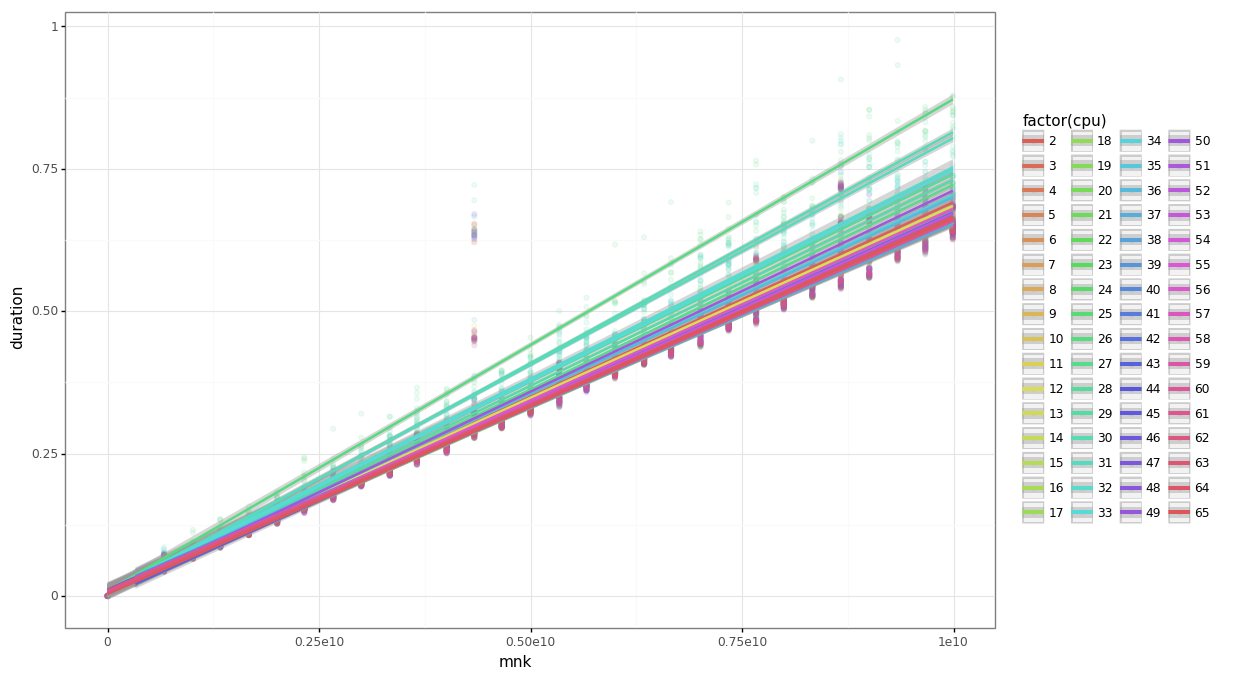

<ggplot: (8779903985384)>

In [3]:
tmp = df[df.mnk < 2e10]
ggplot(tmp.sample(n=10000), aes(x='mnk', y='duration', color='factor(cpu)'))  + geom_point(alpha=0.1) + geom_smooth(method='lm') + theme_bw()

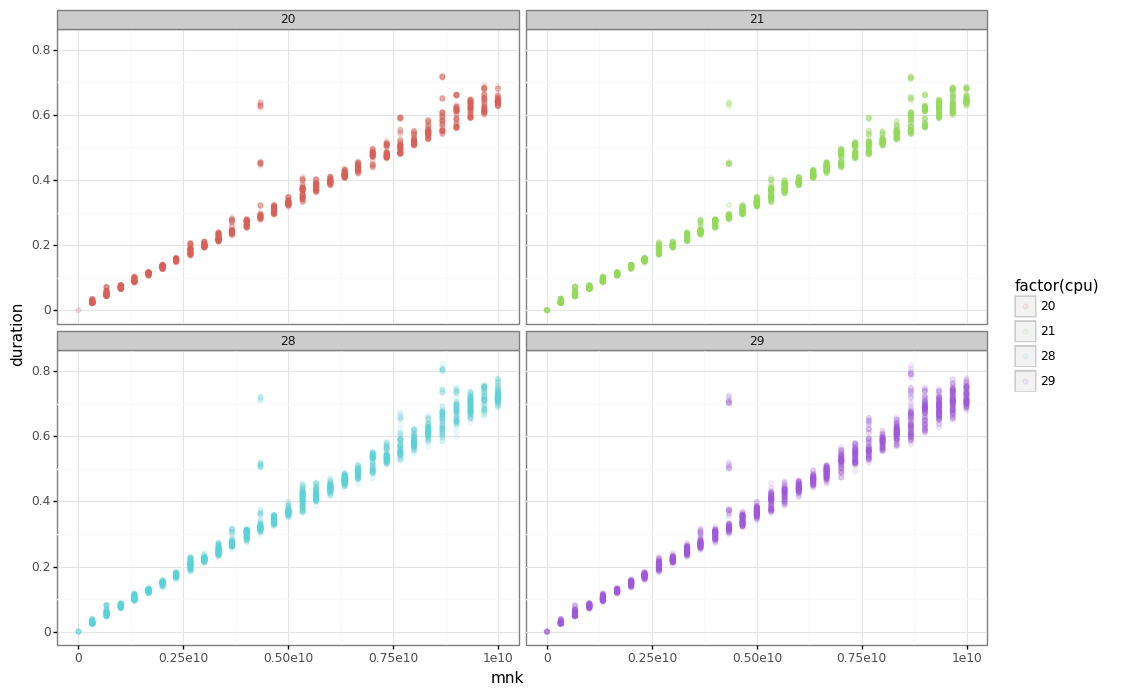

<ggplot: (8779843090089)>

In [4]:
ggplot(tmp[tmp.node.isin([10, 14])].sample(n=10000), aes(x='mnk', y='duration', color='factor(cpu)')) + facet_wrap('cpu') + geom_point(alpha=0.1) + theme_bw()

## Classical regression

We fix the intercept by hand, otherwise it gets too high.

In [5]:
from statsmodels.formula.api import ols
import numpy

def compute_intercept(df, x, y):
    short_calls = df[df[x] <= df[x].min() * 100]  # taking the calls smallet than 100 times the smallest one
    short_calls = short_calls[short_calls[y] < short_calls[y].quantile(0.95)]  # removing the 5% longest calls, we have very large outliers (without this, the intercept is 3 times larger)
    return short_calls[y].mean()

def compute_reg(df, y_var, x_vars, aggregate=False, verbose=False):
    assert 'mnk' in x_vars
    model = '%s ~ %s + 0' % (y_var, ' + '.join(x_vars))
    if verbose:
        print(model)
    df = df.copy()
    if aggregate:
        if aggregate == 'mean':
            df = df.groupby(x_vars)[[y_var]].mean().reset_index()
        elif aggregate == 'std':
            df = df.groupby(x_vars)[[y_var]].std().reset_index()
        else:
            assert False
    intercept = max(0, compute_intercept(df, 'mnk', y_var))
    df[y_var] -= intercept
    reg = ols(formula=model, data=df).fit()
    if verbose:
        print(df.head())
        print(reg.summary())
    return {'intercept': intercept, **{var: reg.params[var] for var in x_vars}}

def predict(df, reg, variables):
    pred = numpy.zeros(len(df))
    pred += reg['intercept']
    for var in variables:
        pred += reg[var] * df[var]
    return pred

def compute_full_reg(df, variables, draw_plot=False, verbose=False):
    df = df.copy()
    reg_duration = compute_reg(df, 'duration', variables, aggregate='mean', verbose=verbose)
    df['pred'] = predict(df, reg_duration, variables)
    df['residual'] = df['duration'] - df['pred']
    reg_residual = compute_reg(df, 'residual', variables, aggregate='std', verbose=verbose)
    for k, v in reg_residual.items():
        reg_duration['%s_residual' % k] = reg_residual[k]
    if draw_plot:
        df['sd_noise'] = predict(df, reg_residual, variables)
        df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
        df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
        df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
        df['noise'] *= df['sigma']
        df['noise'] += df['mu']
        df['pred_noise'] = df['pred'] + df['noise']
        plot = ggplot(df.sample(n=10000), aes(x='mnk')) + geom_point(aes(y='duration'), alpha=0.5) + theme_bw()
        plot1 = plot + geom_point(aes(y='pred'), color='orange', alpha=0.5) + ggtitle('Predictions without noise')
        print(plot1)
        print(plot1 + scale_x_log10() + scale_y_log10())
        plot2 = plot + geom_point(aes(y='pred_noise'), color='lime', alpha=0.5) + ggtitle('Predictions with noise')
        print(plot2)
        print(plot2 + scale_x_log10() + scale_y_log10())
    return reg_duration

duration ~ mnk + mn + mk + nk + 0
         mnk      mn       mk       nk      duration
0          1       1        1        1  0.000000e+00
1         64      16       16       16  1.590778e-07
2  329334390  145530   712845  1045506  2.549775e-02
3  329334390  145530  1045506   712845  2.525567e-02
4  329334390  712845   145530  1045506  2.420196e-02
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.984e+05
Date:                Thu, 04 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:54:19   Log-Likelihood:                 1892.3
No. Observations:                 543   AIC:                            -3777.
Df Residuals:                     539   BIC:                            -3759.
Df Model:       

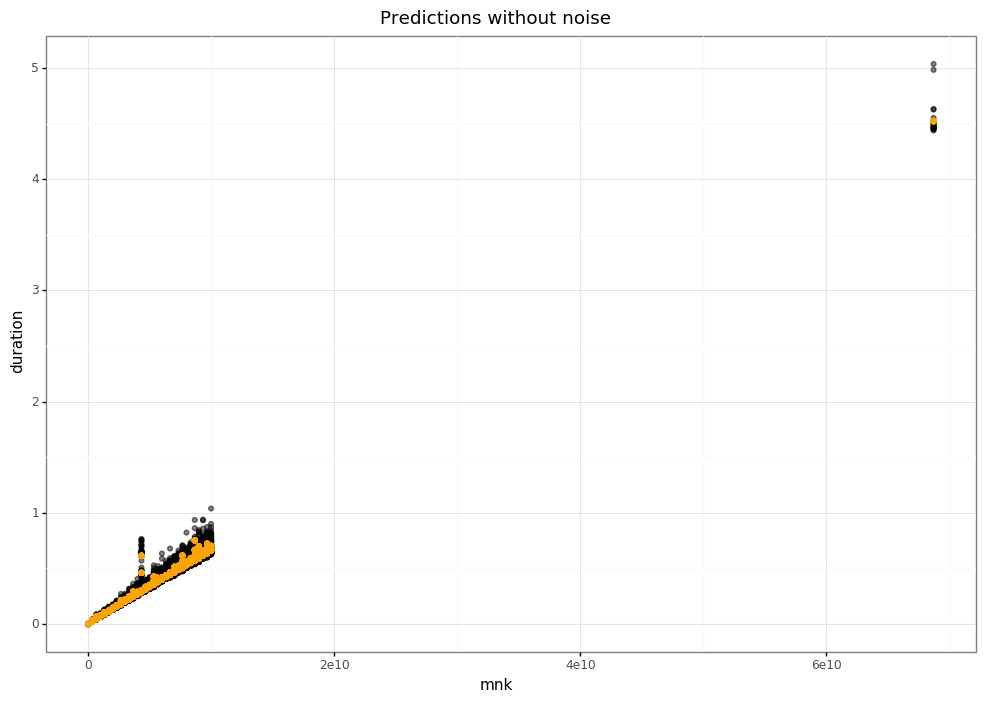

<ggplot: (-9223363257013475282)>


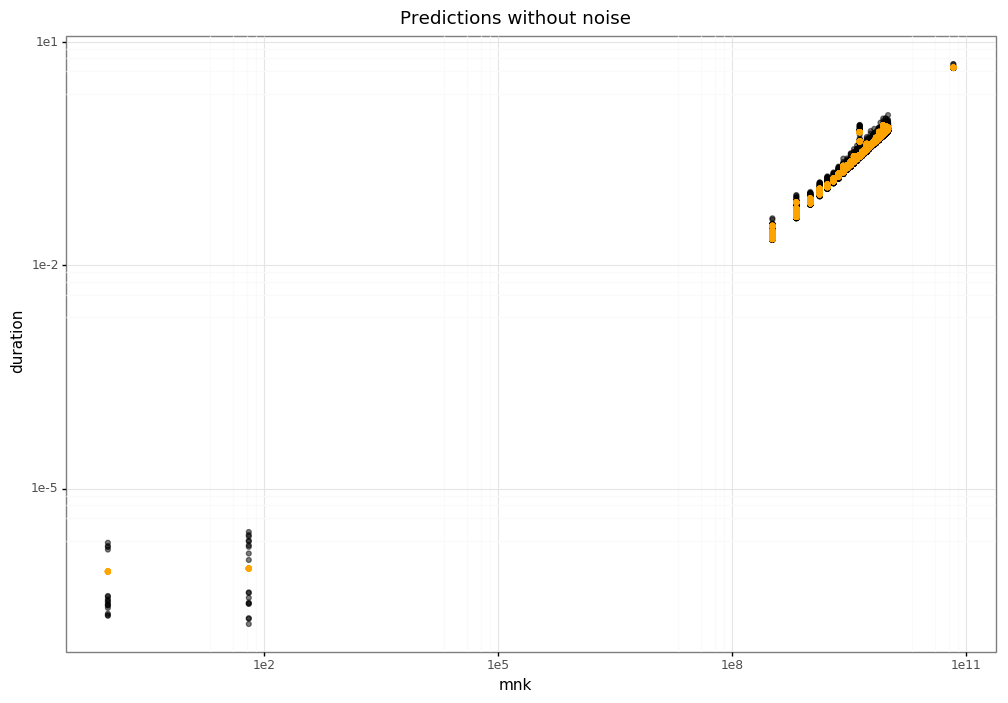

<ggplot: (-9223363257011690187)>


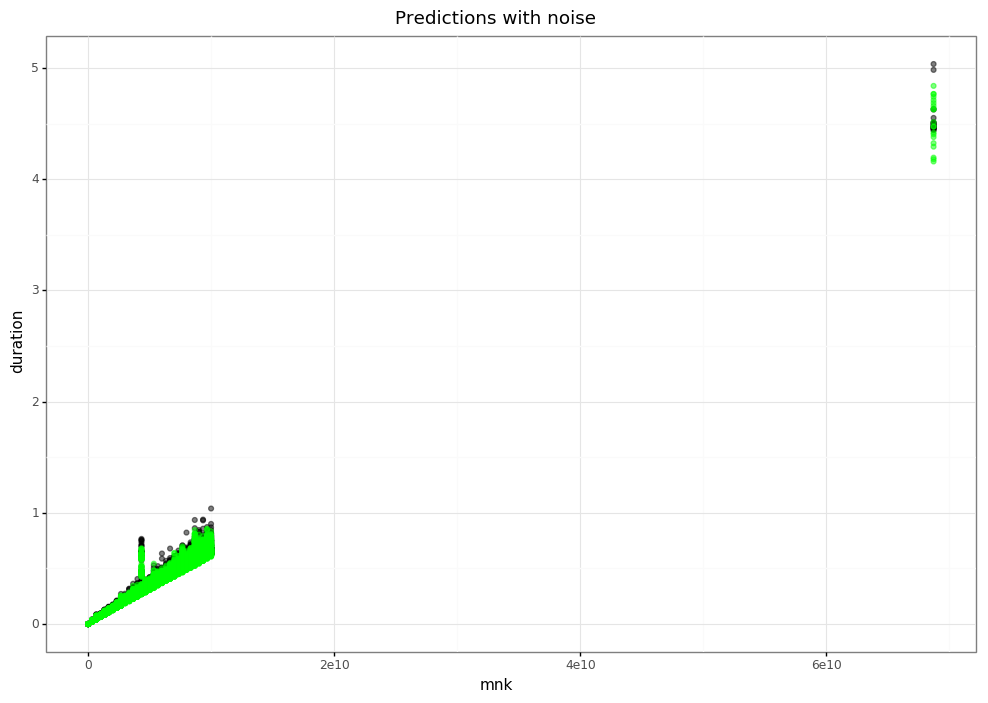

<ggplot: (8779841271630)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


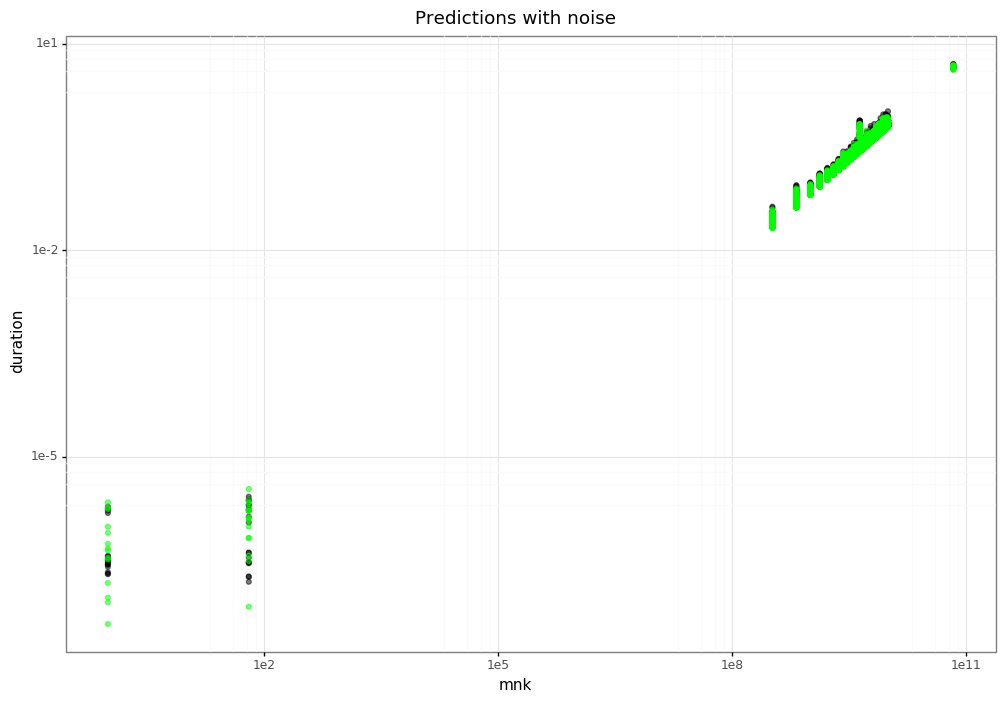

<ggplot: (8779838620925)>
CPU times: user 8.34 s, sys: 3.15 s, total: 11.5 s
Wall time: 9.03 s


{'intercept': 7.664481336805556e-07,
 'mnk': 6.464755139656107e-11,
 'mn': 3.416641143030822e-11,
 'mk': 1.6486901740147043e-09,
 'nk': 3.0673825210451504e-09,
 'intercept_residual': 8.236919941765394e-07,
 'mnk_residual': 4.08128884572224e-12,
 'mn_residual': -6.6879690029199626e-12,
 'mk_residual': 8.01270424293072e-11,
 'nk_residual': 9.062145188083319e-11}

In [6]:
%time reg_global = compute_full_reg(df, ['mnk', 'mn', 'mk', 'nk'], draw_plot=True, verbose=True)
reg_global

## Linear model

In [7]:
def compute_reg_percpu(df, variables):
    reg_local = []
    for cpu in sorted(df['cpu'].unique()):
        tmp = df[df['cpu'] == cpu] 
        reg = compute_full_reg(tmp, variables)
        reg['node'] = tmp['node'].unique()[0]
        reg['cpu'] = cpu
        reg_local.append(reg)
    return reg_local

reg_local = compute_reg_percpu(df, ['mnk'])
reg_local_pandas = pandas.DataFrame(reg_local).drop(['node', 'cpu'], 1)
reg_local_pandas.describe()

,intercept,intercept_residual,mnk,mnk_residual
count,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01
mean,7.661272e-07,7.462142e-07,6.773492e-11,1.175464e-12
std,5.051161e-08,5.822541e-08,4.230159e-12,4.501849e-13
min,7.028750e-07,6.583976e-07,6.522487e-11,9.287125e-13
25%,7.291493e-07,6.997737e-07,6.573981e-11,9.942425e-13
50%,7.565069e-07,7.409213e-07,6.598127e-11,1.015721e-12
75%,7.884618e-07,7.813344e-07,6.709185e-11,1.209499e-12
max,8.925208e-07,8.945470e-07,8.715335e-11,4.130546e-12


In [8]:
def compute_mean_reg(reg):
    mean_reg = {}
    reg = pandas.DataFrame(reg)
    for var in reg.columns:
        if var in ['node', 'cpu']:
            continue
        mean_reg[var] = reg[var].mean()
    return mean_reg

compute_mean_reg(reg_local)

{'intercept': 7.661271701388889e-07,
 'intercept_residual': 7.462141909000303e-07,
 'mnk': 6.773491511897399e-11,
 'mnk_residual': 1.1754638408055209e-12}

In [9]:
def get_reg(reg, residual):
    if residual:
        reg = {k[:-9]: v for k, v in reg.items() if k.endswith('_residual')}
    else:
        reg = {k: v for k, v in reg.items() if not k.endswith('_residual')}
    return reg
    
def model_str(reg, residual=False):
    reg = get_reg(reg, residual)
    parameters = []
    for name, param in reg.items():
        if param == 0:
            continue
        if name != 'intercept':
            parameters.append('%e*%s' % (param, name))
        else:
            parameters.append('%e' % reg[name])
    return ' + '.join(parameters)

def __return_stmt(reg):
    mu    = model_str(reg, False)
    sigma = model_str(reg, True)
    result  = '        mu    = %s;\n' % mu
    result += '        sigma = %s;\n' % sigma
    result += '        return mu + random_halfnormal_shifted(0, sigma);'
    return result

def __reg_to_c(reg):
    tmp = dict(reg)
    del tmp['cpu']
    del tmp['node']
    return '''    case %d: // node %d\n%s''' % (reg['cpu'], reg['node'], __return_stmt(tmp))

def reg_to_c(all_reg):
    result = [__reg_to_c(reg) for reg in all_reg]
    return '\n'.join(result)

def dump_reg(all_reg):
    reg_code = reg_to_c(all_reg)
    reg_code_default = __return_stmt(compute_mean_reg(all_reg))
    reg_code = 'double mu, sigma;\nswitch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, reg_code_default)
    from IPython.display import Markdown, display
    display(Markdown('```c\n%s\n```' % reg_code))

dump_reg(reg_local)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 7.853125e-07 + 6.882427e-11*mnk;
        sigma = 7.830495e-07 + 1.379021e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 7.862778e-07 + 6.606362e-11*mnk;
        sigma = 7.936144e-07 + 1.022787e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 7.452431e-07 + 6.704175e-11*mnk;
        sigma = 7.203726e-07 + 1.308392e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 7.950139e-07 + 6.593482e-11*mnk;
        sigma = 8.100348e-07 + 1.035922e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 7.588889e-07 + 6.693730e-11*mnk;
        sigma = 7.281816e-07 + 1.296870e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 7.102500e-07 + 6.598762e-11*mnk;
        sigma = 6.854477e-07 + 1.022958e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 7.599653e-07 + 6.588353e-11*mnk;
        sigma = 7.507439e-07 + 1.017762e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 7.632708e-07 + 6.582781e-11*mnk;
        sigma = 7.618731e-07 + 1.039891e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 7.311042e-07 + 6.724215e-11*mnk;
        sigma = 6.965018e-07 + 1.336012e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 7.752778e-07 + 6.561885e-11*mnk;
        sigma = 7.751025e-07 + 9.954206e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 7.550972e-07 + 6.856351e-11*mnk;
        sigma = 7.262807e-07 + 1.251864e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 7.563958e-07 + 6.538303e-11*mnk;
        sigma = 7.407432e-07 + 9.743868e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 7.281806e-07 + 6.606305e-11*mnk;
        sigma = 7.070072e-07 + 1.024651e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 7.238958e-07 + 6.524118e-11*mnk;
        sigma = 7.024108e-07 + 9.287125e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 7.317917e-07 + 6.754306e-11*mnk;
        sigma = 7.048715e-07 + 1.281541e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 7.052431e-07 + 6.557470e-11*mnk;
        sigma = 6.583976e-07 + 1.009798e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 7.226319e-07 + 6.566795e-11*mnk;
        sigma = 6.946990e-07 + 9.619655e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 7.091528e-07 + 6.577997e-11*mnk;
        sigma = 7.004421e-07 + 9.670509e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 7.028750e-07 + 6.575380e-11*mnk;
        sigma = 6.612767e-07 + 1.013531e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 8.925208e-07 + 6.580046e-11*mnk;
        sigma = 8.452781e-07 + 1.011390e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 7.162014e-07 + 6.559472e-11*mnk;
        sigma = 6.658692e-07 + 9.793859e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 7.978611e-07 + 6.682011e-11*mnk;
        sigma = 8.153402e-07 + 1.230928e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 7.404722e-07 + 6.567783e-11*mnk;
        sigma = 7.183681e-07 + 9.836142e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 7.165208e-07 + 6.560644e-11*mnk;
        sigma = 6.825284e-07 + 9.668453e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 8.614931e-07 + 8.715335e-11*mnk;
        sigma = 7.467259e-07 + 4.130546e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 7.998403e-07 + 7.238872e-11*mnk;
        sigma = 7.826829e-07 + 1.290631e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 8.661111e-07 + 7.392005e-11*mnk;
        sigma = 8.615136e-07 + 1.543730e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 8.458681e-07 + 7.388078e-11*mnk;
        sigma = 8.508206e-07 + 1.655566e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 8.868611e-07 + 8.095009e-11*mnk;
        sigma = 8.545369e-07 + 1.482240e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 8.442569e-07 + 8.040130e-11*mnk;
        sigma = 8.018829e-07 + 1.705960e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 8.701250e-07 + 7.612516e-11*mnk;
        sigma = 8.700458e-07 + 1.697187e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 8.195764e-07 + 7.531268e-11*mnk;
        sigma = 8.162530e-07 + 2.409316e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 8.552778e-07 + 7.049131e-11*mnk;
        sigma = 8.210168e-07 + 1.162371e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 7.806319e-07 + 6.621796e-11*mnk;
        sigma = 7.808849e-07 + 1.022101e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 7.567778e-07 + 6.989633e-11*mnk;
        sigma = 6.972479e-07 + 1.189376e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 7.417639e-07 + 6.556734e-11*mnk;
        sigma = 7.410993e-07 + 1.012766e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 7.720556e-07 + 6.616183e-11*mnk;
        sigma = 7.710574e-07 + 1.048063e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 7.632986e-07 + 6.578085e-11*mnk;
        sigma = 7.557611e-07 + 9.935760e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 7.491597e-07 + 6.667938e-11*mnk;
        sigma = 7.165639e-07 + 1.163135e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 7.208125e-07 + 6.575188e-11*mnk;
        sigma = 7.012316e-07 + 1.010196e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 8.667639e-07 + 6.611293e-11*mnk;
        sigma = 8.945470e-07 + 1.051782e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 7.099167e-07 + 6.593605e-11*mnk;
        sigma = 6.944355e-07 + 1.013681e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 7.566181e-07 + 6.575221e-11*mnk;
        sigma = 7.468924e-07 + 9.927124e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 7.098264e-07 + 6.597492e-11*mnk;
        sigma = 6.801366e-07 + 1.000566e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 7.168958e-07 + 6.594029e-11*mnk;
        sigma = 6.788702e-07 + 1.007248e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 7.296458e-07 + 6.542952e-11*mnk;
        sigma = 6.951718e-07 + 9.787283e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 7.359444e-07 + 6.585268e-11*mnk;
        sigma = 7.057480e-07 + 1.044465e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 7.400278e-07 + 6.564041e-11*mnk;
        sigma = 7.438531e-07 + 9.769243e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 7.547222e-07 + 7.052465e-11*mnk;
        sigma = 7.184685e-07 + 1.202356e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 7.464028e-07 + 6.522487e-11*mnk;
        sigma = 7.332204e-07 + 9.586603e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 7.492986e-07 + 6.602106e-11*mnk;
        sigma = 7.222841e-07 + 1.012624e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 7.717500e-07 + 6.653518e-11*mnk;
        sigma = 7.639521e-07 + 1.106079e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 7.651250e-07 + 6.613808e-11*mnk;
        sigma = 7.457768e-07 + 1.006456e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 8.109514e-07 + 6.638618e-11*mnk;
        sigma = 8.420998e-07 + 1.136896e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 8.019722e-07 + 6.818664e-11*mnk;
        sigma = 7.849814e-07 + 1.312005e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 7.334514e-07 + 6.579017e-11*mnk;
        sigma = 7.160587e-07 + 9.944646e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 7.049444e-07 + 6.600523e-11*mnk;
        sigma = 6.662907e-07 + 9.916880e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 7.639028e-07 + 6.586872e-11*mnk;
        sigma = 7.766094e-07 + 1.010482e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 7.294722e-07 + 6.607561e-11*mnk;
        sigma = 6.977684e-07 + 1.004114e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 7.161042e-07 + 6.561704e-11*mnk;
        sigma = 6.800425e-07 + 9.727869e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 7.124861e-07 + 6.567434e-11*mnk;
        sigma = 6.691238e-07 + 9.987693e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 7.675000e-07 + 6.584819e-11*mnk;
        sigma = 7.717235e-07 + 9.954486e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 7.628542e-07 + 6.570358e-11*mnk;
        sigma = 7.526269e-07 + 9.444321e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 8.322083e-07 + 6.568548e-11*mnk;
        sigma = 7.792672e-07 + 9.588609e-13*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 7.661272e-07 + 6.773492e-11*mnk;
        sigma = 7.462142e-07 + 1.175464e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

## Polynomial model

In [10]:
reg_local_poly = compute_reg_percpu(df, ['mnk', 'mn', 'mk', 'nk'])
reg_local_poly_pandas = pandas.DataFrame(reg_local_poly).drop(['node', 'cpu'], 1)
reg_local_poly_pandas.describe()

,intercept,intercept_residual,mk,mk_residual,mn,mn_residual,mnk,mnk_residual,nk,nk_residual
count,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01
mean,7.661272e-07,7.462142e-07,1.648690e-09,2.846888e-11,3.416642e-11,1.185692e-11,6.464755e-11,3.983680e-13,3.067383e-09,3.073464e-11
std,5.051161e-08,5.822541e-08,8.306966e-11,1.256060e-11,3.165295e-11,2.052789e-11,4.052001e-12,5.773027e-13,9.952269e-11,1.953226e-11
min,7.028750e-07,6.583976e-07,1.557606e-09,1.534072e-11,-5.740823e-11,-4.778763e-12,6.235041e-11,1.080842e-13,2.954058e-09,-6.027291e-11
25%,7.291493e-07,6.997737e-07,1.607174e-09,2.166482e-11,1.143418e-11,2.354216e-12,6.277263e-11,1.547462e-13,3.016071e-09,2.507452e-11
50%,7.565069e-07,7.409213e-07,1.625889e-09,2.428683e-11,4.677665e-11,4.759421e-12,6.298588e-11,1.862923e-13,3.045530e-09,3.103184e-11
75%,7.884618e-07,7.813344e-07,1.645461e-09,2.937476e-11,5.436684e-11,9.019283e-12,6.394483e-11,4.634868e-13,3.075681e-09,3.420074e-11
max,8.925208e-07,8.945470e-07,1.924190e-09,7.859658e-11,1.235821e-10,9.583930e-11,8.363197e-11,4.055846e-12,3.414540e-09,9.979883e-11


In [11]:
dump_reg(reg_local_poly)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 7.853125e-07 + 6.552563e-11*mnk + -1.978567e-11*mn + 1.646106e-09*mk + 2.967994e-09*nk;
        sigma = 7.830495e-07 + 7.301704e-13*mnk + 2.317844e-11*mn + 3.466127e-11*mk + 3.180054e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 7.862778e-07 + 6.304137e-11*mnk + 4.117781e-11*mn + 1.633952e-09*mk + 3.083172e-09*nk;
        sigma = 7.936144e-07 + 1.527798e-13*mnk + 3.364380e-12*mn + 2.346102e-11*mk + 3.371050e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 7.452431e-07 + 6.392285e-11*mnk + 1.556738e-11*mn + 1.679895e-09*mk + 3.047643e-09*nk;
        sigma = 7.203726e-07 + 5.375326e-13*mnk + 7.970948e-13*mn + 2.339729e-11*mk + 1.496193e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 7.950139e-07 + 6.293876e-11*mnk + 4.201792e-11*mn + 1.638565e-09*mk + 3.076754e-09*nk;
        sigma = 8.100348e-07 + 1.934471e-13*mnk + 1.650635e-12*mn + 2.020890e-11*mk + 2.417719e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 7.588889e-07 + 6.376802e-11*mnk + 6.274304e-12*mn + 1.654261e-09*mk + 3.045778e-09*nk;
        sigma = 7.281816e-07 + 4.978252e-13*mnk + -1.684358e-12*mn + 2.285048e-11*mk + 5.083534e-13*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 7.102500e-07 + 6.301192e-11*mnk + 5.573379e-11*mn + 1.611717e-09*mk + 3.057569e-09*nk;
        sigma = 6.854477e-07 + 1.872062e-13*mnk + 4.182302e-12*mn + 2.042538e-11*mk + 2.481538e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 7.599653e-07 + 6.290189e-11*mnk + 5.442433e-11*mn + 1.624846e-09*mk + 3.037214e-09*nk;
        sigma = 7.507439e-07 + 1.853783e-13*mnk + 8.065444e-12*mn + 2.444285e-11*mk + 3.185019e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 7.632708e-07 + 6.287576e-11*mnk + 6.060831e-11*mn + 1.626577e-09*mk + 3.075323e-09*nk;
        sigma = 7.618731e-07 + 2.398523e-13*mnk + 4.742514e-12*mn + 3.006709e-11*mk + 3.601954e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 7.311042e-07 + 6.401078e-11*mnk + 3.497772e-12*mn + 1.645377e-09*mk + 3.048318e-09*nk;
        sigma = 6.965018e-07 + 5.956946e-13*mnk + -4.778763e-12*mn + 2.071657e-11*mk + 6.245376e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 7.752778e-07 + 6.263179e-11*mnk + 3.771101e-11*mn + 1.569714e-09*mk + 2.993787e-09*nk;
        sigma = 7.751025e-07 + 1.403500e-13*mnk + -2.487272e-12*mn + 2.273718e-11*mk + 2.099514e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 7.550972e-07 + 6.534617e-11*mnk + -1.565230e-11*mn + 1.645712e-09*mk + 2.998035e-09*nk;
        sigma = 7.262807e-07 + 5.100991e-13*mnk + 7.892200e-12*mn + 2.134522e-11*mk + 3.262724e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 7.563958e-07 + 6.250004e-11*mnk + 6.203304e-11*mn + 1.562579e-09*mk + 2.975829e-09*nk;
        sigma = 7.407432e-07 + 1.593519e-13*mnk + 7.310959e-12*mn + 1.821013e-11*mk + 2.712362e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 7.281806e-07 + 6.304984e-11*mnk + 4.555101e-11*mn + 1.644459e-09*mk + 3.073881e-09*nk;
        sigma = 7.070072e-07 + 1.616045e-13*mnk + -3.576157e-14*mn + 2.885449e-11*mk + 2.608187e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 7.238958e-07 + 6.236209e-11*mnk + 5.907931e-11*mn + 1.557606e-09*mk + 2.958309e-09*nk;
        sigma = 7.024108e-07 + 1.080842e-13*mnk + 2.313234e-12*mn + 2.750739e-11*mk + 2.516090e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 7.317917e-07 + 6.426163e-11*mnk + -1.446626e-11*mn + 1.618376e-09*mk + 3.045706e-09*nk;
        sigma = 7.048715e-07 + 5.275110e-13*mnk + 6.573549e-12*mn + 2.176400e-11*mk + 1.666005e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 7.052431e-07 + 6.262474e-11*mnk + 4.913346e-11*mn + 1.608911e-09*mk + 3.027520e-09*nk;
        sigma = 6.583976e-07 + 1.548434e-13*mnk + -2.557374e-13*mn + 2.163638e-11*mk + 2.964638e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 7.226319e-07 + 6.274478e-11*mnk + 5.185995e-11*mn + 1.586136e-09*mk + 2.971264e-09*nk;
        sigma = 6.946990e-07 + 1.549806e-13*mnk + 9.640814e-12*mn + 2.900631e-11*mk + 3.679289e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 7.091528e-07 + 6.280890e-11*mnk + 5.176882e-11*mn + 1.612611e-09*mk + 3.038783e-09*nk;
        sigma = 7.004421e-07 + 1.336087e-13*mnk + 9.249330e-12*mn + 3.222452e-11*mk + 3.753194e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 7.028750e-07 + 6.282286e-11*mnk + 5.785318e-11*mn + 1.628587e-09*mk + 3.020194e-09*nk;
        sigma = 6.612767e-07 + 1.922337e-13*mnk + 7.485767e-12*mn + 1.980241e-11*mk + 3.271731e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 8.925208e-07 + 6.284188e-11*mnk + 5.840074e-11*mn + 1.622961e-09*mk + 3.014349e-09*nk;
        sigma = 8.452781e-07 + 1.886173e-13*mnk + 1.341004e-12*mn + 2.897210e-11*mk + 2.940980e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 7.162014e-07 + 6.264806e-11*mnk + 5.227355e-11*mn + 1.584727e-09*mk + 2.976753e-09*nk;
        sigma = 6.658692e-07 + 1.440036e-13*mnk + 3.415177e-12*mn + 1.803155e-11*mk + 2.322538e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 7.978611e-07 + 6.360445e-11*mnk + -1.019730e-11*mn + 1.631177e-09*mk + 3.035922e-09*nk;
        sigma = 8.153402e-07 + 4.099322e-13*mnk + -1.343484e-12*mn + 2.358211e-11*mk + 4.701430e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 7.404722e-07 + 6.273481e-11*mnk + 5.944892e-11*mn + 1.611569e-09*mk + 3.022937e-09*nk;
        sigma = 7.183681e-07 + 1.613769e-13*mnk + 5.754657e-12*mn + 2.461214e-11*mk + 3.609302e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 7.165208e-07 + 6.268844e-11*mnk + 4.482782e-11*mn + 1.569436e-09*mk + 2.954058e-09*nk;
        sigma = 6.825284e-07 + 1.554238e-13*mnk + 4.776329e-12*mn + 2.513834e-11*mk + 3.400817e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 8.614931e-07 + 8.363197e-11*mnk + 1.235821e-10*mn + 1.867653e-09*mk + 3.311537e-09*nk;
        sigma = 7.467259e-07 + 4.055846e-12*mnk + 4.229149e-11*mn + 2.697547e-11*mk + -6.027291e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 7.998403e-07 + 6.903098e-11*mnk + -1.282893e-11*mn + 1.701176e-09*mk + 3.068559e-09*nk;
        sigma = 7.826829e-07 + 5.120057e-13*mnk + 8.956747e-12*mn + 3.474547e-11*mk + 1.502711e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 8.661111e-07 + 7.045091e-11*mnk + 7.866923e-12*mn + 1.872889e-09*mk + 3.379813e-09*nk;
        sigma = 8.615136e-07 + 8.969032e-13*mnk + 4.595603e-11*mn + 4.832763e-11*mk + 3.773301e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 8.458681e-07 + 7.032189e-11*mnk + -2.070010e-11*mn + 1.843896e-09*mk + 3.278262e-09*nk;
        sigma = 8.508206e-07 + 1.141266e-12*mnk + 5.785083e-11*mn + 5.531853e-11*mk + 5.714635e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 8.868611e-07 + 7.731433e-11*mnk + -3.414959e-11*mn + 1.924190e-09*mk + 3.378364e-09*nk;
        sigma = 8.545369e-07 + 9.355831e-13*mnk + 8.827586e-11*mn + 6.004368e-11*mk + 9.979883e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 8.442569e-07 + 7.676121e-11*mnk + -1.177156e-11*mn + 1.901475e-09*mk + 3.414540e-09*nk;
        sigma = 8.018829e-07 + 1.272220e-12*mnk + 9.583930e-11*mn + 7.859658e-11*mk + 9.110183e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 8.701250e-07 + 7.250044e-11*mnk + -5.740823e-11*mn + 1.788183e-09*mk + 3.227756e-09*nk;
        sigma = 8.700458e-07 + 1.192453e-12*mnk + 6.488012e-11*mn + 5.578576e-11*mk + 6.185332e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 8.195764e-07 + 7.187064e-11*mnk + -9.519227e-12*mn + 1.826610e-09*mk + 3.251198e-09*nk;
        sigma = 8.162530e-07 + 1.973832e-12*mnk + 5.908575e-11*mn + 7.758032e-11*mk + 3.399154e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 8.552778e-07 + 6.725486e-11*mnk + 2.130974e-11*mn + 1.721460e-09*mk + 3.154475e-09*nk;
        sigma = 8.210168e-07 + 3.962091e-13*mnk + 2.293843e-11*mn + 2.759609e-11*mk + 5.537112e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 7.806319e-07 + 6.319873e-11*mnk + 4.837630e-11*mn + 1.640451e-09*mk + 3.083425e-09*nk;
        sigma = 7.808849e-07 + 1.883612e-13*mnk + 8.374862e-12*mn + 2.339639e-11*mk + 3.297920e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 7.567778e-07 + 6.667916e-11*mnk + 9.307286e-13*mn + 1.697504e-09*mk + 3.029054e-09*nk;
        sigma = 6.972479e-07 + 4.610156e-13*mnk + 2.018655e-11*mn + 3.881888e-11*mk + 4.947483e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 7.417639e-07 + 6.263498e-11*mnk + 5.212403e-11*mn + 1.582683e-09*mk + 3.016645e-09*nk;
        sigma = 7.410993e-07 + 1.486358e-13*mnk + 8.524724e-13*mn + 1.534072e-11*mk + 3.192914e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 7.720556e-07 + 6.315674e-11*mnk + 4.211722e-11*mn + 1.652036e-09*mk + 3.063165e-09*nk;
        sigma = 7.710574e-07 + 2.791675e-13*mnk + 6.541851e-12*mn + 2.756517e-11*mk + 3.169034e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 7.632986e-07 + 6.281066e-11*mnk + 4.579095e-11*mn + 1.619068e-09*mk + 3.029073e-09*nk;
        sigma = 7.557611e-07 + 1.268702e-13*mnk + 1.605752e-12*mn + 2.410352e-11*mk + 2.859489e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 7.491597e-07 + 6.352890e-11*mnk + 9.888044e-12*mn + 1.634866e-09*mk + 3.041314e-09*nk;
        sigma = 7.165639e-07 + 3.189615e-13*mnk + -3.149172e-12*mn + 2.395403e-11*mk + 1.689295e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 7.208125e-07 + 6.280547e-11*mnk + 5.215841e-11*mn + 1.606464e-09*mk + 3.046943e-09*nk;
        sigma = 7.012316e-07 + 1.904036e-13*mnk + 3.225577e-12*mn + 1.700835e-11*mk + 2.032748e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 8.667639e-07 + 6.310783e-11*mnk + 5.143572e-11*mn + 1.640278e-09*mk + 3.054570e-09*nk;
        sigma = 8.945470e-07 + 2.055946e-13*mnk + 6.464070e-12*mn + 2.413082e-11*mk + 2.679531e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 7.099167e-07 + 6.289665e-11*mnk + 3.433049e-11*mn + 1.624593e-09*mk + 3.055766e-09*nk;
        sigma = 6.944355e-07 + 1.436240e-13*mnk + 3.381094e-12*mn + 3.007505e-11*mk + 3.445594e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 7.566181e-07 + 6.278191e-11*mnk + 4.757771e-11*mn + 1.594519e-09*mk + 3.020856e-09*nk;
        sigma = 7.468924e-07 + 1.558398e-13*mnk + 1.788502e-12*mn + 2.923324e-11*mk + 2.420049e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 7.098264e-07 + 6.295717e-11*mnk + 4.503349e-11*mn + 1.633723e-09*mk + 3.089743e-09*nk;
        sigma = 6.801366e-07 + 1.379419e-13*mnk + 3.647956e-12*mn + 2.504436e-11*mk + 2.681257e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 7.168958e-07 + 6.295985e-11*mnk + 6.518486e-11*mn + 1.637810e-09*mk + 3.087150e-09*nk;
        sigma = 6.788702e-07 + 1.638924e-13*mnk + 4.717076e-12*mn + 2.465917e-11*mk + 2.887925e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 7.296458e-07 + 6.251290e-11*mnk + 5.315716e-11*mn + 1.571289e-09*mk + 3.003688e-09*nk;
        sigma = 6.951718e-07 + 1.576510e-13*mnk + 5.827457e-12*mn + 2.167430e-11*mk + 3.163820e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 7.359444e-07 + 6.289210e-11*mnk + 5.693404e-11*mn + 1.609502e-09*mk + 3.045355e-09*nk;
        sigma = 7.057480e-07 + 2.577536e-13*mnk + 2.367877e-12*mn + 2.338444e-11*mk + 3.222819e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 7.400278e-07 + 6.269631e-11*mnk + 4.933222e-11*mn + 1.585690e-09*mk + 3.024324e-09*nk;
        sigma = 7.438531e-07 + 1.275308e-13*mnk + 3.990637e-12*mn + 2.368717e-11*mk + 3.716550e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 7.547222e-07 + 6.730013e-11*mnk + 1.310900e-11*mn + 1.698670e-09*mk + 3.100322e-09*nk;
        sigma = 7.184685e-07 + 4.709002e-13*mnk + 2.252721e-11*mn + 3.685923e-11*mk + 5.271457e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 7.464028e-07 + 6.235041e-11*mnk + 6.996696e-11*mn + 1.560595e-09*mk + 2.993696e-09*nk;
        sigma = 7.332204e-07 + 1.105175e-13*mnk + 9.206893e-12*mn + 2.028102e-11*mk + 2.721001e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 7.492986e-07 + 6.304056e-11*mnk + 5.546836e-11*mn + 1.623786e-09*mk + 3.069448e-09*nk;
        sigma = 7.222841e-07 + 1.840252e-13*mnk + 4.978283e-12*mn + 2.043221e-11*mk + 3.207240e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 7.717500e-07 + 6.342294e-11*mnk + 2.497478e-11*mn + 1.640974e-09*mk + 3.086003e-09*nk;
        sigma = 7.639521e-07 + 2.674480e-13*mnk + 2.790270e-12*mn + 1.950937e-11*mk + 1.918734e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 7.651250e-07 + 6.309067e-11*mnk + 3.768114e-11*mn + 1.639342e-09*mk + 3.071980e-09*nk;
        sigma = 7.457768e-07 + 1.637174e-13*mnk + 1.321352e-12*mn + 3.404235e-11*mk + 3.049643e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 8.109514e-07 + 6.324411e-11*mnk + 1.194955e-11*mn + 1.625201e-09*mk + 3.046140e-09*nk;
        sigma = 8.420998e-07 + 2.833606e-13*mnk + -3.600717e-12*mn + 2.003500e-11*mk + 2.288858e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 8.019722e-07 + 6.495346e-11*mnk + -1.402946e-11*mn + 1.644404e-09*mk + 2.979273e-09*nk;
        sigma = 7.849814e-07 + 5.976790e-13*mnk + 1.084200e-11*mn + 2.160918e-11*mk + 3.156725e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 7.334514e-07 + 6.280426e-11*mnk + 4.711430e-11*mn + 1.604015e-09*mk + 3.034339e-09*nk;
        sigma = 7.160587e-07 + 1.267977e-13*mnk + 2.783661e-12*mn + 2.881425e-11*mk + 3.190014e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 7.049444e-07 + 6.302085e-11*mnk + 5.879933e-11*mn + 1.642256e-09*mk + 3.103210e-09*nk;
        sigma = 6.662907e-07 + 1.544546e-13*mnk + 6.262154e-12*mn + 2.544455e-11*mk + 3.590933e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 7.639028e-07 + 6.288524e-11*mnk + 5.070018e-11*mn + 1.621587e-09*mk + 3.053942e-09*nk;
        sigma = 7.766094e-07 + 1.626040e-13*mnk + 4.376434e-12*mn + 2.188227e-11*mk + 2.821745e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 7.294722e-07 + 6.313607e-11*mnk + 5.320227e-11*mn + 1.603183e-09*mk + 3.009502e-09*nk;
        sigma = 6.977684e-07 + 1.741587e-13*mnk + 4.578121e-12*mn + 2.189809e-11*mk + 2.982559e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 7.161042e-07 + 6.265998e-11*mnk + 5.221565e-11*mn + 1.610662e-09*mk + 3.024270e-09*nk;
        sigma = 6.800425e-07 + 1.169760e-13*mnk + 7.969270e-12*mn + 2.979931e-11*mk + 3.411567e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 7.124861e-07 + 6.272913e-11*mnk + 5.497526e-11*mn + 1.601275e-09*mk + 3.003896e-09*nk;
        sigma = 6.691238e-07 + 1.785181e-13*mnk + 3.059165e-12*mn + 2.356662e-11*mk + 2.954429e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 7.675000e-07 + 6.290422e-11*mnk + 5.984324e-11*mn + 1.622918e-09*mk + 3.030605e-09*nk;
        sigma = 7.717235e-07 + 1.556426e-13*mnk + 4.135460e-12*mn + 2.725657e-11*mk + 2.817528e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 7.628542e-07 + 6.273503e-11*mnk + 5.434768e-11*mn + 1.607411e-09*mk + 3.012020e-09*nk;
        sigma = 7.526269e-07 + 1.467298e-13*mnk + 1.322611e-11*mn + 3.002862e-11*mk + 4.106918e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 8.322083e-07 + 6.274217e-11*mnk + 4.643900e-11*mn + 1.576031e-09*mk + 2.991170e-09*nk;
        sigma = 7.792672e-07 + 1.405511e-13*mnk + 7.341557e-12*mn + 1.984973e-11*mk + 2.944503e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 7.661272e-07 + 1.648690e-09*mk + 3.416642e-11*mn + 6.464755e-11*mnk + 3.067383e-09*nk;
        sigma = 7.462142e-07 + 2.846888e-11*mk + 1.185692e-11*mn + 3.983680e-13*mnk + 3.073464e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Visualization (linear model)

In [12]:
def compute_predictions(df, reg_local, variables):
    for reg in reg_local:
        tmp = df[df['cpu'] == reg['cpu']]
        reg_duration = get_reg(reg, residual=False)
        df.loc[df['cpu'] == reg['cpu'], 'prediction'] = predict(tmp, reg_duration, variables)
        reg_residual = get_reg(reg, residual=True)
        df.loc[df['cpu'] == reg['cpu'], 'sd_noise'] = predict(tmp, reg_residual, variables)
    df['sigma'] = df['sd_noise']/numpy.sqrt(1-2/numpy.pi)
    df['mu'] = -df['sigma']*numpy.sqrt(2/numpy.pi)
    df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
    df['noise'] *= df['sigma']
    df['noise'] += df['mu']
    df['pred_noise'] = df['prediction'] + df['noise']

compute_predictions(df, reg_local, ['mnk'])
df.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
0,dgemm,378,7640,2427,3473.428414,0.485947,10,0,0,True,...,7008981840,2887920,917406,18542280,0.460868,0.007104,0.011786,-0.009404,-0.002731,0.458137
1,dgemm,378,7640,2427,3473.914385,0.486129,10,1,1,False,...,7008981840,2887920,917406,18542280,0.460868,0.007104,0.011786,-0.009404,0.000504,0.461372
2,dgemm,378,7640,2427,3474.400522,0.486853,10,2,2,False,...,7008981840,2887920,917406,18542280,0.460868,0.007104,0.011786,-0.009404,0.007845,0.468713
3,dgemm,9441,640,1160,3474.887383,0.455139,10,3,0,True,...,7008998400,6042240,10951560,742400,0.460869,0.007104,0.011786,-0.009404,-0.005638,0.455231
4,dgemm,9441,640,1160,3475.342530,0.453528,10,4,1,False,...,7008998400,6042240,10951560,742400,0.460869,0.007104,0.011786,-0.009404,0.009940,0.470809


In [13]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,20,10,7008981840,duration,0.485947
1,20,10,7008981840,duration,0.486129
2,20,10,7008981840,duration,0.486853
3,20,10,7008998400,duration,0.455139
4,20,10,7008998400,duration,0.453528


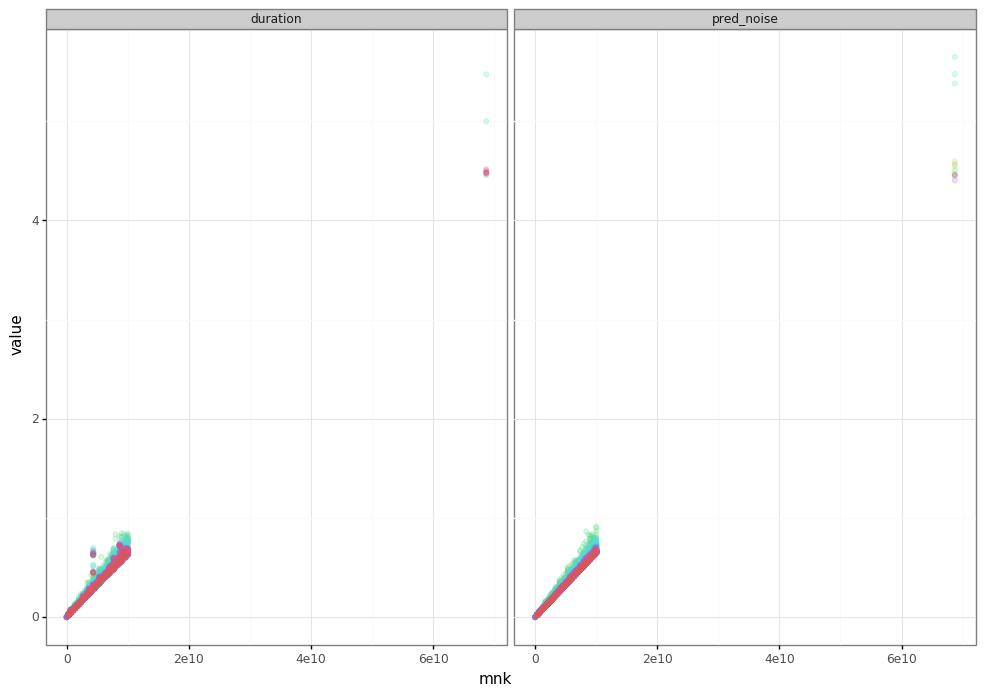

<ggplot: (8779838348664)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


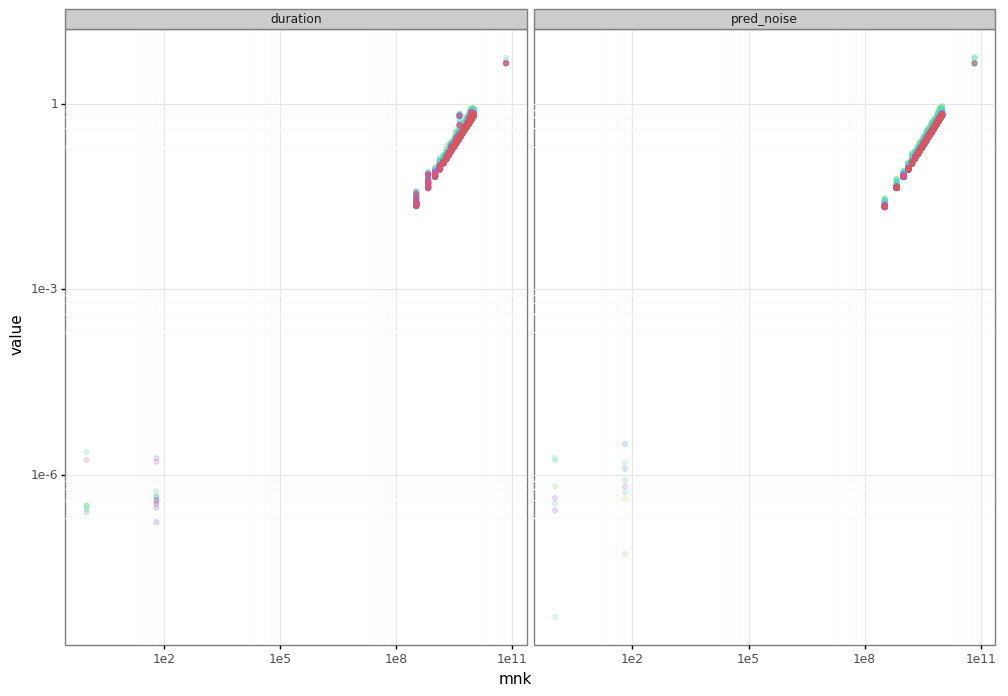

<ggplot: (-9223363257006157901)>


In [14]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Visualization (polynomial model)

In [15]:
compute_predictions(df, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
df.head()

,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,...,mnk,mn,mk,nk,prediction,sd_noise,sigma,mu,noise,pred_noise
0,dgemm,378,7640,2427,3473.428414,0.485947,10,0,0,True,...,7008981840,2887920,917406,18542280,0.497987,0.001994,0.003309,-0.002640,-0.000719,0.497268
1,dgemm,378,7640,2427,3473.914385,0.486129,10,1,1,False,...,7008981840,2887920,917406,18542280,0.497987,0.001994,0.003309,-0.002640,-0.000615,0.497372
2,dgemm,378,7640,2427,3474.400522,0.486853,10,2,2,False,...,7008981840,2887920,917406,18542280,0.497987,0.001994,0.003309,-0.002640,0.001165,0.499153
3,dgemm,9441,640,1160,3474.887383,0.455139,10,3,0,True,...,7008998400,6042240,10951560,742400,0.460753,0.001634,0.002711,-0.002163,-0.001259,0.459494
4,dgemm,9441,640,1160,3475.342530,0.453528,10,4,1,False,...,7008998400,6042240,10951560,742400,0.460753,0.001634,0.002711,-0.002163,-0.000063,0.460691


In [16]:
tmp = df.melt(id_vars=['cpu', 'node', 'mnk'], value_vars=['duration', 'pred_noise'])
tmp.head()

,cpu,node,mnk,variable,value
0,20,10,7008981840,duration,0.485947
1,20,10,7008981840,duration,0.486129
2,20,10,7008981840,duration,0.486853
3,20,10,7008998400,duration,0.455139
4,20,10,7008998400,duration,0.453528


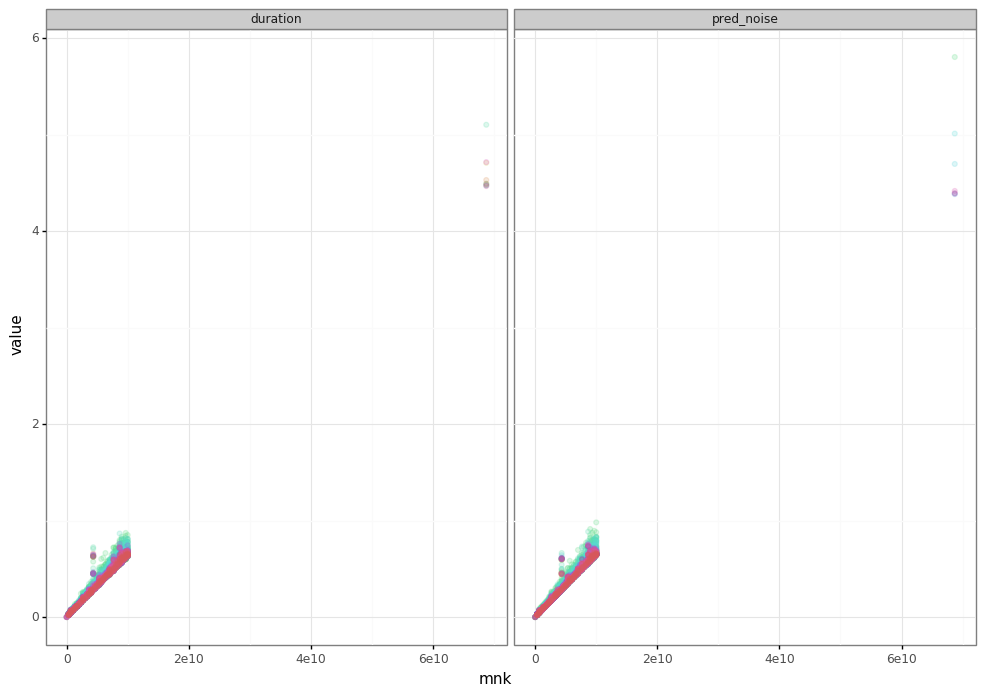

<ggplot: (-9223363257013503712)>


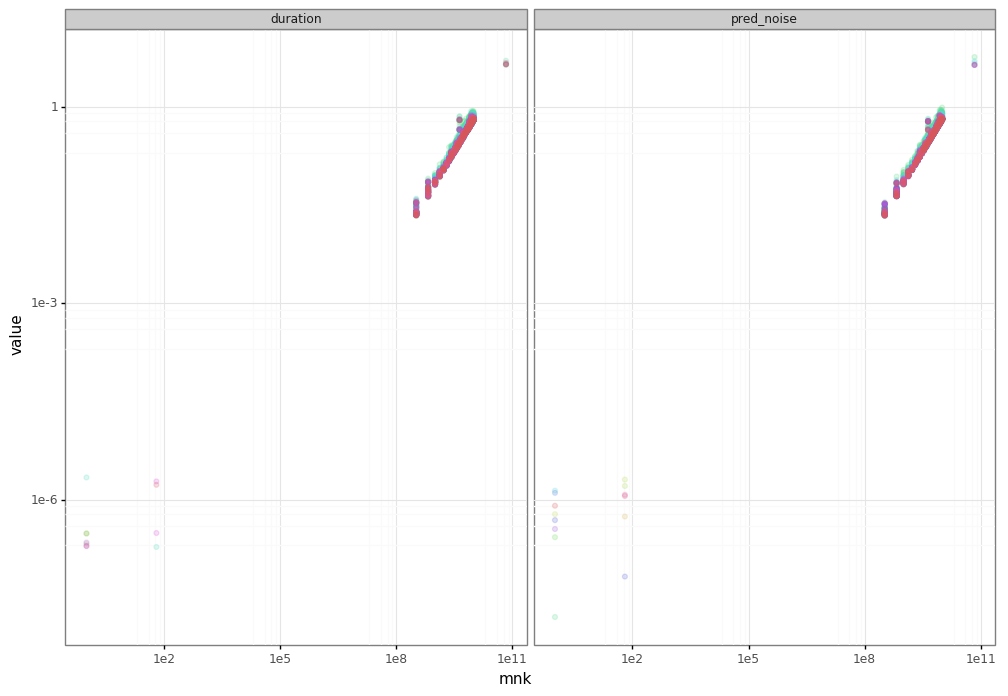

<ggplot: (8779841269999)>


In [17]:
plot = ggplot(tmp.sample(n=10000), aes(x='mnk', y='value', color='factor(cpu)')) + geom_point(alpha=0.2) + theme_bw() + facet_wrap('variable') + scale_color_discrete(guide=False)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

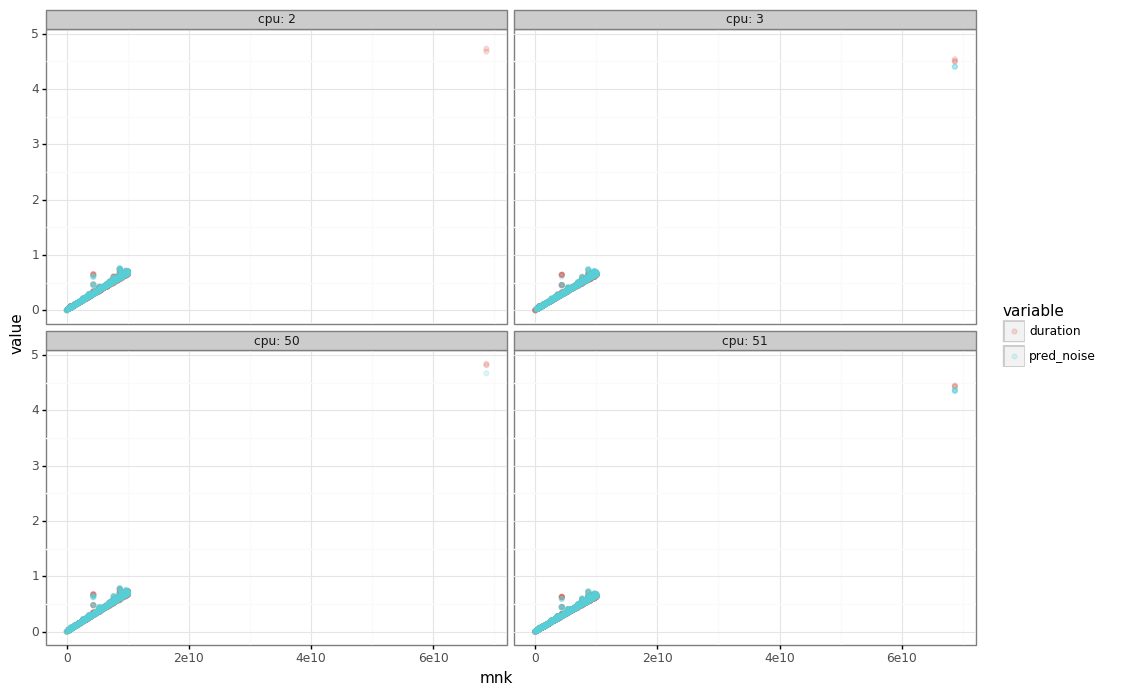

<ggplot: (8779841337664)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: invalid value encountered in log10
  return self.trans.transform(x)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


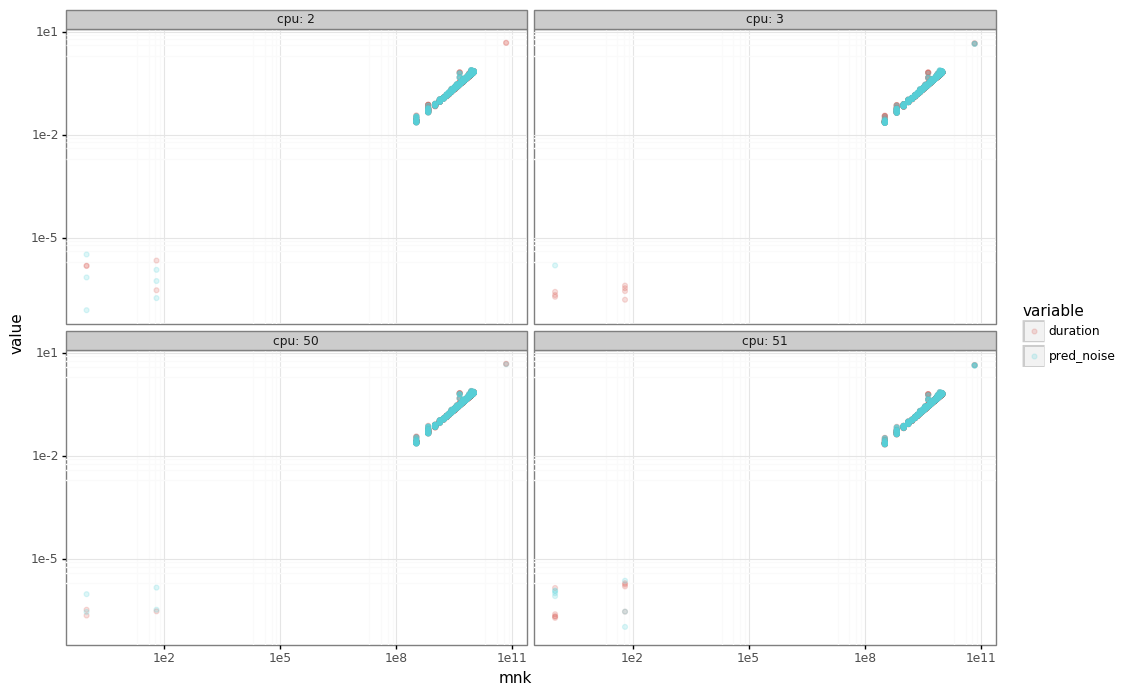

<ggplot: (-9223363257016445601)>


In [18]:
plot = ggplot(tmp[tmp.node.isin([1, 25])].sample(n=10000), aes(x='mnk', y='value', color='variable')) + geom_point(alpha=0.2) + theme_bw()
plot = plot + facet_wrap('cpu', labeller='label_both')
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Validation of the polynomial model on HPL data

In [19]:
hpl_archive = '../hpl/grenoble_2019-03-28_1856800.zip'
sizes = list(read_csv(hpl_archive, 'results.csv').matrix_size)

blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
hpl_dgemm = []
for i, size in enumerate(sizes):
    blas_trace = read_csv(hpl_archive, 'trace_blas_%d.csv' % i, columns=blas_col)
    blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    blas_trace['function'] = blas_trace['function'].str.strip()
    blas_trace = blas_trace[blas_trace['function'] == 'dgemm']
    hpl_dgemm.append(blas_trace)
hpl_dgemm = pandas.concat(hpl_dgemm)

df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
hpl_dgemm['size_product'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k

In [20]:
hpl_dgemm['mnk'] = hpl_dgemm.m * hpl_dgemm.n * hpl_dgemm.k
hpl_dgemm['mn'] = hpl_dgemm.m * hpl_dgemm.n
hpl_dgemm['mk'] = hpl_dgemm.m * hpl_dgemm.k
hpl_dgemm['nk'] = hpl_dgemm.n * hpl_dgemm.k

# The following supposes that HPL was executed on dahu-{1, 2, 3, ...} and that the ranks were mapped in order
hpl_dgemm['core'] = hpl_dgemm['rank']
hpl_dgemm['node'] = 1 + hpl_dgemm['rank'] // 32
hpl_dgemm['cpu'] = 2*hpl_dgemm['node'] + hpl_dgemm['core']%2

In [21]:
compute_predictions(hpl_dgemm, reg_local_poly, ['mnk', 'mn', 'mk', 'nk'])
hpl_dgemm.head()

,file,line,function,rank,timestamp,duration,m,n,k,origin,...,nk,core,node,cpu,prediction,sd_noise,sigma,mu,noise,pred_noise
13,../HPL_pdrpanrlT.c,224,dgemm,0,14.47309,0.000200,50046.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000177,0.000007,0.000011,-0.000009,-7.336669e-07,0.000176
29,../HPL_pdrpanrlT.c,224,dgemm,0,14.47358,0.000380,50044.0,4.0,4.0,HPL,...,16.0,0,1,2,0.000379,0.000013,0.000021,-0.000017,-1.262636e-05,0.000366
43,../HPL_pdrpanrlT.c,224,dgemm,0,14.47421,0.000166,50042.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000177,0.000007,0.000011,-0.000009,7.787842e-06,0.000184
66,../HPL_pdrpanrlT.c,224,dgemm,0,14.47468,0.000751,50040.0,8.0,8.0,HPL,...,64.0,0,1,2,0.000862,0.000026,0.000044,-0.000035,-1.219651e-05,0.000850
81,../HPL_pdrpanrlT.c,224,dgemm,0,14.47579,0.000177,50038.0,2.0,2.0,HPL,...,4.0,0,1,2,0.000177,0.000007,0.000011,-0.000009,-4.340660e-06,0.000172


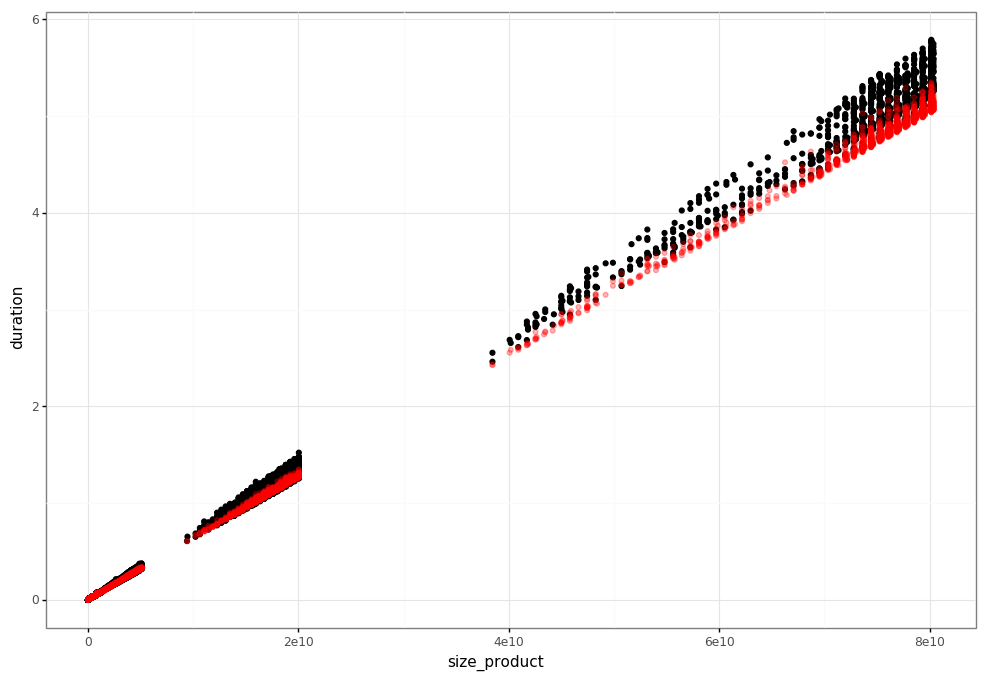

<ggplot: (-9223363257016568951)>


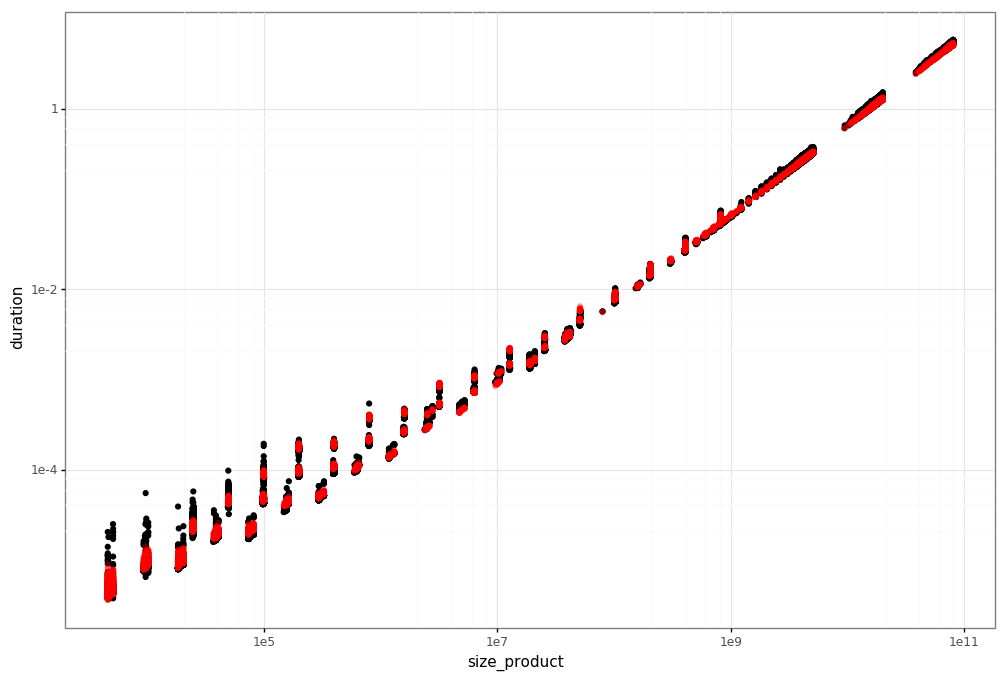

<ggplot: (-9223363257016570445)>


In [22]:
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

### Checking that the calibration data is reasonably close to HPL data

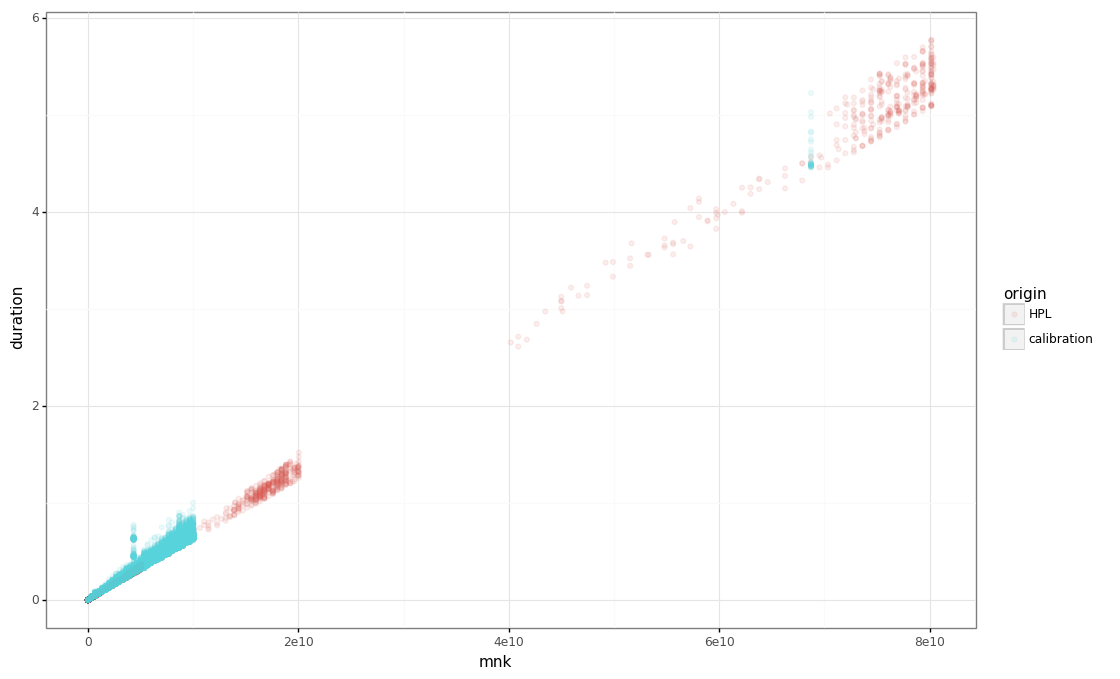

<ggplot: (-9223363257016438524)>


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 415 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


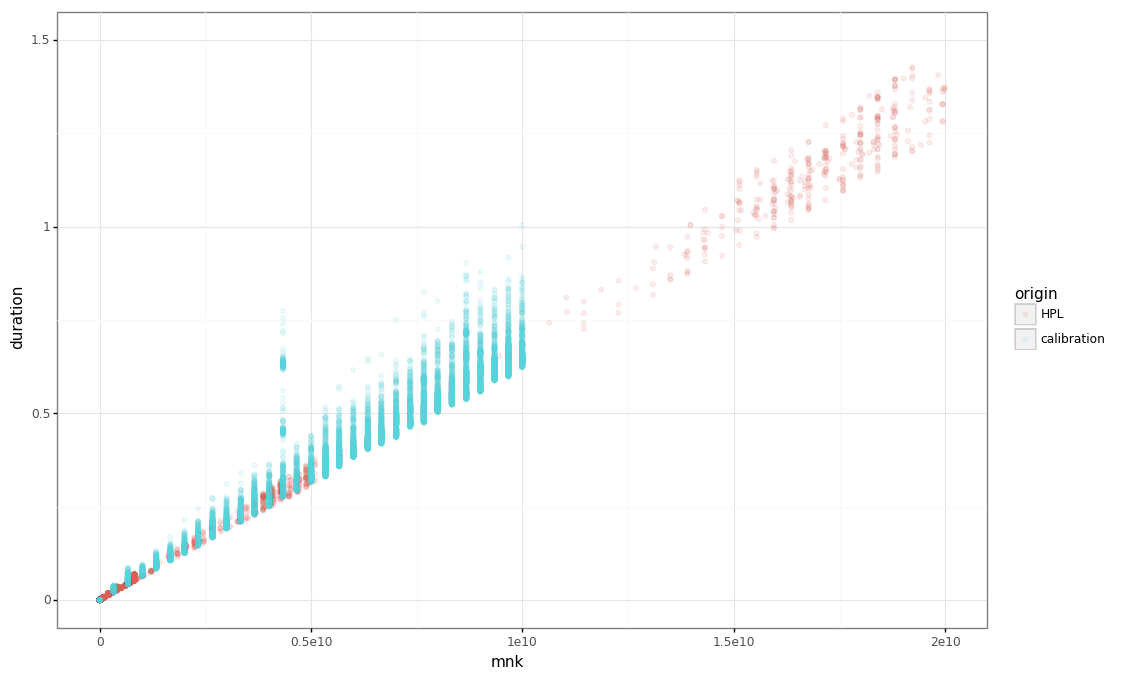

<ggplot: (-9223363256951462554)>


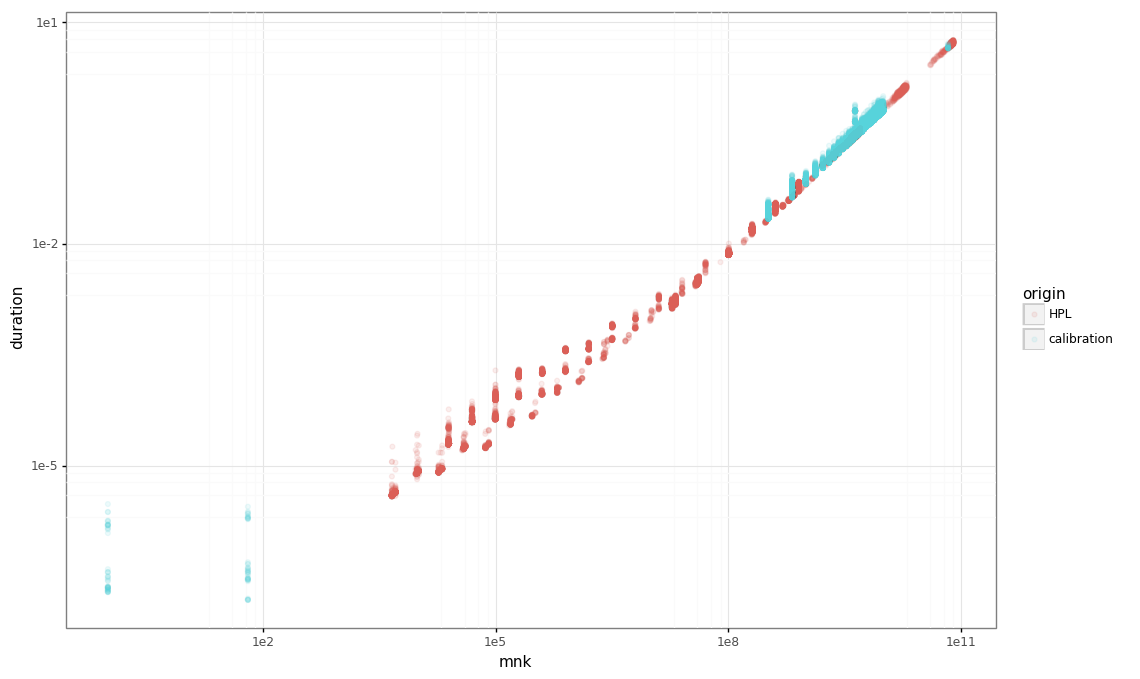

<ggplot: (8779903270429)>


In [23]:
df['origin'] = 'calibration'
hpl_dgemm['origin'] = 'HPL'
tmp = pandas.concat([hpl_dgemm.sample(n=20000), df.sample(n=20000)])
plot = ggplot(tmp) + geom_point(aes(x='mnk', y='duration', color='origin'), alpha=0.1) + theme_bw()
print(plot)
print(plot + xlim(0, 2e10) + ylim(0, 1.5))
print(plot + scale_x_log10() + scale_y_log10())

### Unbiasing the calibration (linear model)

We will only modify the `mnk` coefficient, so let's restrict ourselves to the largest sizes.

In [24]:
tmp = hpl_dgemm[hpl_dgemm.mnk > 1e10].copy()

To compute the bias factor, we compute the total **real** duration and the total **simulated** duration, then their ratio.

In [25]:
compute_predictions(tmp, reg_local, ['mnk'])
real_t = tmp.duration.sum()
pred_t = tmp.prediction.sum()
print('%.2f  |  %.2f' % (real_t, pred_t))
ratio_mnk = real_t / pred_t
ratio_mnk

7784.04  |  7682.86


1.0131691395756202

Now, let's keep the sizes that have been executed enough time (otherwise, `std` computation does not make much sense).

We will do the same thing than above, but with the mean of the standard deviations (grouped per size).

In [26]:
counts = tmp.groupby('mnk')[['m']].count().reset_index()
sizes = counts[counts.m > 30].mnk
print(len(sizes))
tmp = tmp[tmp.mnk.isin(sizes)]

28


In [27]:
real_std = tmp.groupby('mnk').duration.std().mean()
pred_std = tmp.groupby('mnk').pred_noise.std().mean()
print('%.2e  |  %.2e' % (real_std, pred_std))
ratio_mnk_residual = real_std / pred_std
ratio_mnk_residual

1.17e-01  |  7.30e-02


1.6070343797646016

Finally, we "unbias" the regression with those ratios.

In [28]:
for reg in reg_local:
    reg['mnk'] *= ratio_mnk
    reg['mnk_residual'] *= ratio_mnk_residual

Now, we draw the plot to validate our new model:

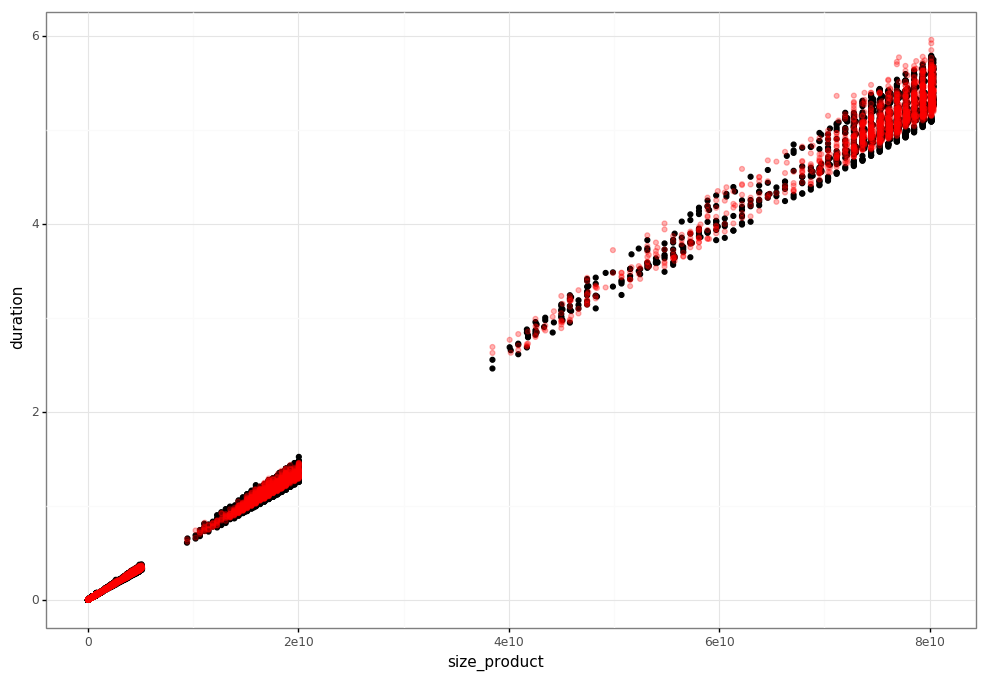

<ggplot: (8779903160454)>


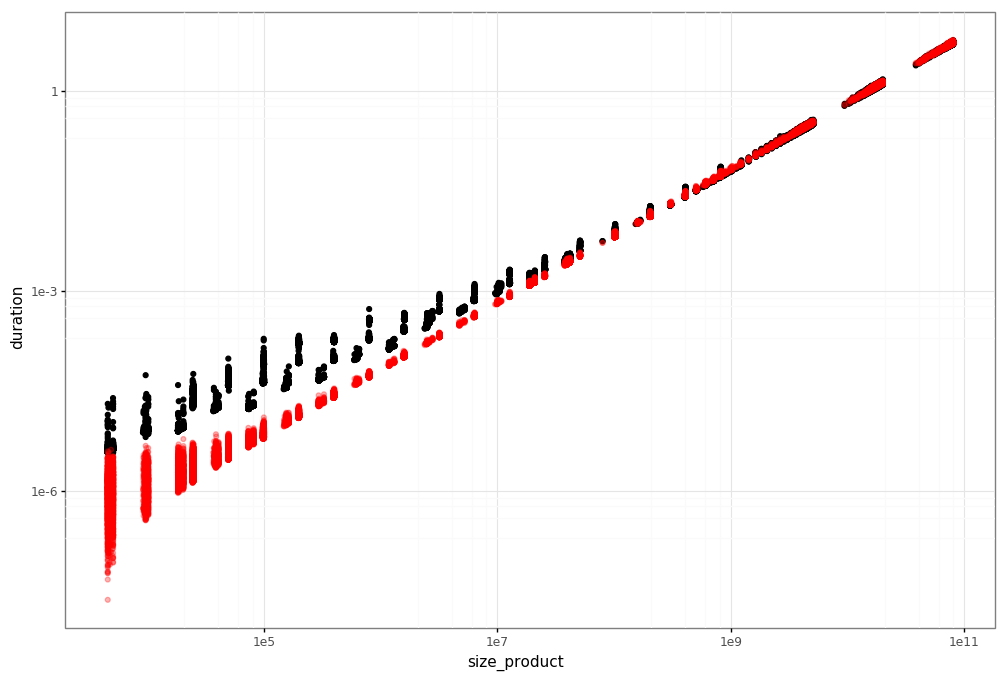

<ggplot: (-9223363257013371318)>


In [29]:
compute_predictions(hpl_dgemm, reg_local, ['mnk'])
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

And we dump the C code for this model:

In [30]:
dump_reg(reg_local)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 7.853125e-07 + 6.973063e-11*mnk;
        sigma = 7.830495e-07 + 2.216134e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 7.862778e-07 + 6.693362e-11*mnk;
        sigma = 7.936144e-07 + 1.643654e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 7.452431e-07 + 6.792463e-11*mnk;
        sigma = 7.203726e-07 + 2.102630e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 7.950139e-07 + 6.680312e-11*mnk;
        sigma = 8.100348e-07 + 1.664762e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 7.588889e-07 + 6.781881e-11*mnk;
        sigma = 7.281816e-07 + 2.084114e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 7.102500e-07 + 6.685662e-11*mnk;
        sigma = 6.854477e-07 + 1.643928e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 7.599653e-07 + 6.675115e-11*mnk;
        sigma = 7.507439e-07 + 1.635578e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 7.632708e-07 + 6.669471e-11*mnk;
        sigma = 7.618731e-07 + 1.671140e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 7.311042e-07 + 6.812768e-11*mnk;
        sigma = 6.965018e-07 + 2.147017e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 7.752778e-07 + 6.648299e-11*mnk;
        sigma = 7.751025e-07 + 1.599675e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 7.550972e-07 + 6.946643e-11*mnk;
        sigma = 7.262807e-07 + 2.011788e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 7.563958e-07 + 6.624406e-11*mnk;
        sigma = 7.407432e-07 + 1.565873e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 7.281806e-07 + 6.693304e-11*mnk;
        sigma = 7.070072e-07 + 1.646649e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 7.238958e-07 + 6.610036e-11*mnk;
        sigma = 7.024108e-07 + 1.492473e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 7.317917e-07 + 6.843255e-11*mnk;
        sigma = 7.048715e-07 + 2.059480e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 7.052431e-07 + 6.643827e-11*mnk;
        sigma = 6.583976e-07 + 1.622780e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 7.226319e-07 + 6.653274e-11*mnk;
        sigma = 6.946990e-07 + 1.545912e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 7.091528e-07 + 6.664623e-11*mnk;
        sigma = 7.004421e-07 + 1.554084e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 7.028750e-07 + 6.661972e-11*mnk;
        sigma = 6.612767e-07 + 1.628779e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 8.925208e-07 + 6.666700e-11*mnk;
        sigma = 8.452781e-07 + 1.625339e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 7.162014e-07 + 6.645854e-11*mnk;
        sigma = 6.658692e-07 + 1.573907e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 7.978611e-07 + 6.770007e-11*mnk;
        sigma = 8.153402e-07 + 1.978144e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 7.404722e-07 + 6.654275e-11*mnk;
        sigma = 7.183681e-07 + 1.580702e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 7.165208e-07 + 6.647042e-11*mnk;
        sigma = 6.825284e-07 + 1.553754e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 8.614931e-07 + 8.830108e-11*mnk;
        sigma = 7.467259e-07 + 6.637930e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 7.998403e-07 + 7.334201e-11*mnk;
        sigma = 7.826829e-07 + 2.074089e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 8.661111e-07 + 7.489351e-11*mnk;
        sigma = 8.615136e-07 + 2.480827e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 8.458681e-07 + 7.485373e-11*mnk;
        sigma = 8.508206e-07 + 2.660551e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 8.868611e-07 + 8.201613e-11*mnk;
        sigma = 8.545369e-07 + 2.382010e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 8.442569e-07 + 8.146011e-11*mnk;
        sigma = 8.018829e-07 + 2.741536e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 8.701250e-07 + 7.712766e-11*mnk;
        sigma = 8.700458e-07 + 2.727439e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 8.195764e-07 + 7.630448e-11*mnk;
        sigma = 8.162530e-07 + 3.871853e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 8.552778e-07 + 7.141962e-11*mnk;
        sigma = 8.210168e-07 + 1.867971e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 7.806319e-07 + 6.709000e-11*mnk;
        sigma = 7.808849e-07 + 1.642551e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 7.567778e-07 + 7.081680e-11*mnk;
        sigma = 6.972479e-07 + 1.911369e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 7.417639e-07 + 6.643081e-11*mnk;
        sigma = 7.410993e-07 + 1.627549e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 7.720556e-07 + 6.703313e-11*mnk;
        sigma = 7.710574e-07 + 1.684273e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 7.632986e-07 + 6.664713e-11*mnk;
        sigma = 7.557611e-07 + 1.596711e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 7.491597e-07 + 6.755749e-11*mnk;
        sigma = 7.165639e-07 + 1.869197e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 7.208125e-07 + 6.661778e-11*mnk;
        sigma = 7.012316e-07 + 1.623420e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 8.667639e-07 + 6.698358e-11*mnk;
        sigma = 8.945470e-07 + 1.690250e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 7.099167e-07 + 6.680438e-11*mnk;
        sigma = 6.944355e-07 + 1.629020e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 7.566181e-07 + 6.661811e-11*mnk;
        sigma = 7.468924e-07 + 1.595323e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 7.098264e-07 + 6.684375e-11*mnk;
        sigma = 6.801366e-07 + 1.607944e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 7.168958e-07 + 6.680867e-11*mnk;
        sigma = 6.788702e-07 + 1.618681e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 7.296458e-07 + 6.629117e-11*mnk;
        sigma = 6.951718e-07 + 1.572850e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 7.359444e-07 + 6.671990e-11*mnk;
        sigma = 7.057480e-07 + 1.678492e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 7.400278e-07 + 6.650484e-11*mnk;
        sigma = 7.438531e-07 + 1.569951e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 7.547222e-07 + 7.145340e-11*mnk;
        sigma = 7.184685e-07 + 1.932228e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 7.464028e-07 + 6.608383e-11*mnk;
        sigma = 7.332204e-07 + 1.540600e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 7.492986e-07 + 6.689050e-11*mnk;
        sigma = 7.222841e-07 + 1.627321e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 7.717500e-07 + 6.741140e-11*mnk;
        sigma = 7.639521e-07 + 1.777507e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 7.651250e-07 + 6.700906e-11*mnk;
        sigma = 7.457768e-07 + 1.617409e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 8.109514e-07 + 6.726043e-11*mnk;
        sigma = 8.420998e-07 + 1.827031e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 8.019722e-07 + 6.908460e-11*mnk;
        sigma = 7.849814e-07 + 2.108438e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 7.334514e-07 + 6.665657e-11*mnk;
        sigma = 7.160587e-07 + 1.598139e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 7.049444e-07 + 6.687446e-11*mnk;
        sigma = 6.662907e-07 + 1.593677e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 7.639028e-07 + 6.673615e-11*mnk;
        sigma = 7.766094e-07 + 1.623879e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 7.294722e-07 + 6.694576e-11*mnk;
        sigma = 6.977684e-07 + 1.613646e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 7.161042e-07 + 6.648116e-11*mnk;
        sigma = 6.800425e-07 + 1.563302e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 7.124861e-07 + 6.653921e-11*mnk;
        sigma = 6.691238e-07 + 1.605057e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 7.675000e-07 + 6.671535e-11*mnk;
        sigma = 7.717235e-07 + 1.599720e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 7.628542e-07 + 6.656884e-11*mnk;
        sigma = 7.526269e-07 + 1.517735e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 8.322083e-07 + 6.655050e-11*mnk;
        sigma = 7.792672e-07 + 1.540922e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 7.661272e-07 + 6.862693e-11*mnk;
        sigma = 7.462142e-07 + 1.889011e-12*mnk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```

### Unbiasing the calibration (polynomial model)

We will only modify the `mnk` coefficient, so let's restrict ourselves to the largest sizes.

In [31]:
tmp = hpl_dgemm[hpl_dgemm.mnk > 1e10].copy()

To compute the bias factor, we compute the total **real** duration and the total **simulated** duration, then their ratio.

In [32]:
compute_predictions(tmp, reg_local_poly, ['mnk', 'mn', 'nk', 'mk'])
real_t = tmp.duration.sum()
pred_t = tmp.prediction.sum()
print('%.2f  |  %.2f' % (real_t, pred_t))
ratio_mnk = real_t / pred_t
ratio_mnk

7784.04  |  7384.97


1.0540375577020527

Now, let's keep the sizes that have been executed enough time (otherwise, `std` computation does not make much sense).

We will do the same thing than above, but with the mean of the standard deviations (grouped per size).

In [33]:
counts = tmp.groupby(['mnk', 'mn', 'mk', 'nk'])[['m']].count().reset_index()
sizes = counts[counts.m > 30].mnk
print(len(sizes))
tmp = tmp[tmp.mnk.isin(sizes)]

28


In [34]:
real_std = tmp.groupby('mnk').duration.std().mean()
pred_std = tmp.groupby('mnk').pred_noise.std().mean()
print('%.2e  |  %.2e' % (real_std, pred_std))
ratio_mnk_residual = real_std / pred_std
ratio_mnk_residual

1.17e-01  |  3.91e-02


2.9956542956799104

Finally, we "unbias" the regression with those ratios.

In [35]:
for reg in reg_local_poly:
    reg['mnk'] *= ratio_mnk
    reg['mnk_residual'] *= ratio_mnk_residual

Now, we draw the plot to validate our new model:

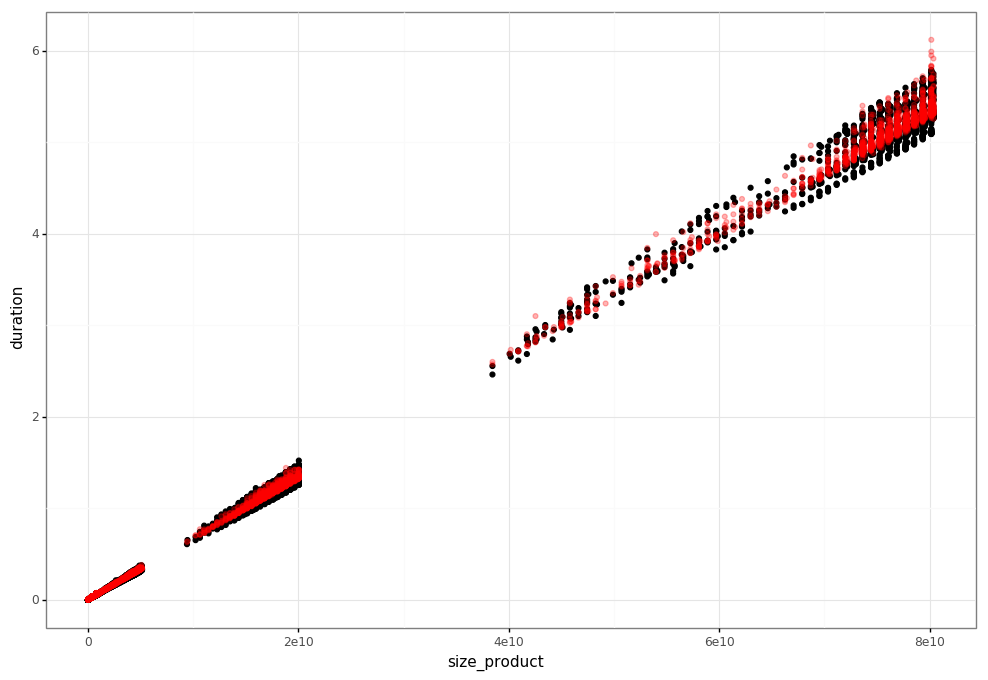

<ggplot: (-9223363257013370087)>


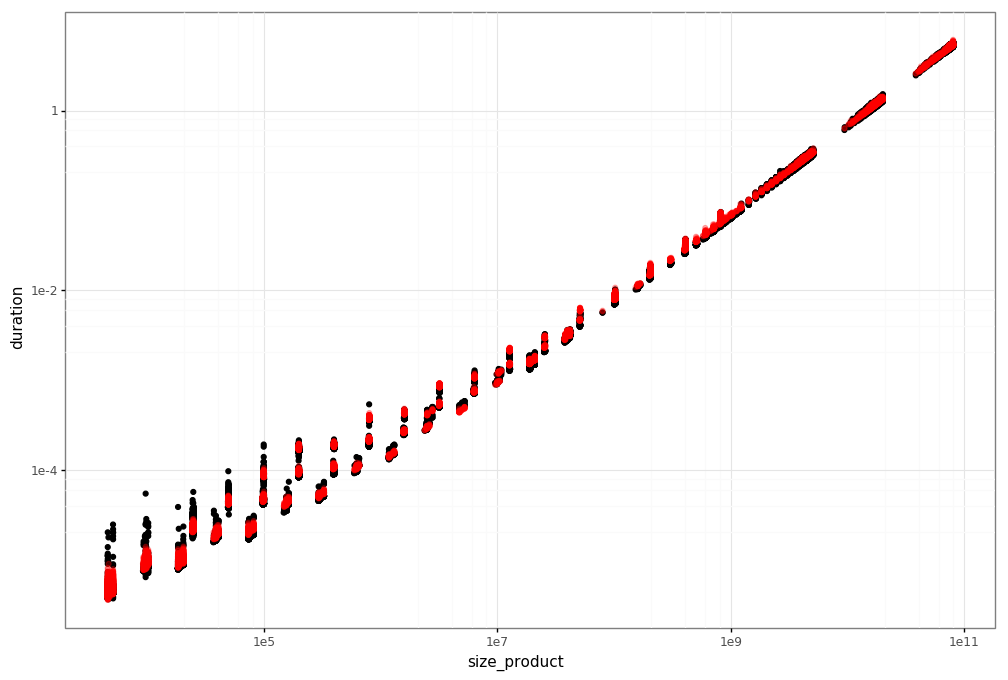

<ggplot: (-9223363257006098158)>


In [36]:
compute_predictions(hpl_dgemm, reg_local_poly, ['mnk', 'mn', 'nk', 'mk'])
plot = ggplot(hpl_dgemm) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw()
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

And we dump the C code for this model:

In [37]:
dump_reg(reg_local_poly)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 7.853125e-07 + 6.906647e-11*mnk + -1.978567e-11*mn + 1.646106e-09*mk + 2.967994e-09*nk;
        sigma = 7.830495e-07 + 2.187338e-12*mnk + 2.317844e-11*mn + 3.466127e-11*mk + 3.180054e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 7.862778e-07 + 6.644797e-11*mnk + 4.117781e-11*mn + 1.633952e-09*mk + 3.083172e-09*nk;
        sigma = 7.936144e-07 + 4.576755e-13*mnk + 3.364380e-12*mn + 2.346102e-11*mk + 3.371050e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 7.452431e-07 + 6.737708e-11*mnk + 1.556738e-11*mn + 1.679895e-09*mk + 3.047643e-09*nk;
        sigma = 7.203726e-07 + 1.610262e-12*mnk + 7.970948e-13*mn + 2.339729e-11*mk + 1.496193e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 7.950139e-07 + 6.633982e-11*mnk + 4.201792e-11*mn + 1.638565e-09*mk + 3.076754e-09*nk;
        sigma = 8.100348e-07 + 5.795006e-13*mnk + 1.650635e-12*mn + 2.020890e-11*mk + 2.417719e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 7.588889e-07 + 6.721389e-11*mnk + 6.274304e-12*mn + 1.654261e-09*mk + 3.045778e-09*nk;
        sigma = 7.281816e-07 + 1.491312e-12*mnk + -1.684358e-12*mn + 2.285048e-11*mk + 5.083534e-13*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 7.102500e-07 + 6.641693e-11*mnk + 5.573379e-11*mn + 1.611717e-09*mk + 3.057569e-09*nk;
        sigma = 6.854477e-07 + 5.608050e-13*mnk + 4.182302e-12*mn + 2.042538e-11*mk + 2.481538e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 7.599653e-07 + 6.630095e-11*mnk + 5.442433e-11*mn + 1.624846e-09*mk + 3.037214e-09*nk;
        sigma = 7.507439e-07 + 5.553294e-13*mnk + 8.065444e-12*mn + 2.444285e-11*mk + 3.185019e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 7.632708e-07 + 6.627341e-11*mnk + 6.060831e-11*mn + 1.626577e-09*mk + 3.075323e-09*nk;
        sigma = 7.618731e-07 + 7.185146e-13*mnk + 4.742514e-12*mn + 3.006709e-11*mk + 3.601954e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 7.311042e-07 + 6.746977e-11*mnk + 3.497772e-12*mn + 1.645377e-09*mk + 3.048318e-09*nk;
        sigma = 6.965018e-07 + 1.784495e-12*mnk + -4.778763e-12*mn + 2.071657e-11*mk + 6.245376e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 7.752778e-07 + 6.601625e-11*mnk + 3.771101e-11*mn + 1.569714e-09*mk + 2.993787e-09*nk;
        sigma = 7.751025e-07 + 4.204401e-13*mnk + -2.487272e-12*mn + 2.273718e-11*mk + 2.099514e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 7.550972e-07 + 6.887732e-11*mnk + -1.565230e-11*mn + 1.645712e-09*mk + 2.998035e-09*nk;
        sigma = 7.262807e-07 + 1.528081e-12*mnk + 7.892200e-12*mn + 2.134522e-11*mk + 3.262724e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 7.563958e-07 + 6.587739e-11*mnk + 6.203304e-11*mn + 1.562579e-09*mk + 2.975829e-09*nk;
        sigma = 7.407432e-07 + 4.773632e-13*mnk + 7.310959e-12*mn + 1.821013e-11*mk + 2.712362e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 7.281806e-07 + 6.645690e-11*mnk + 4.555101e-11*mn + 1.644459e-09*mk + 3.073881e-09*nk;
        sigma = 7.070072e-07 + 4.841112e-13*mnk + -3.576157e-14*mn + 2.885449e-11*mk + 2.608187e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 7.238958e-07 + 6.573198e-11*mnk + 5.907931e-11*mn + 1.557606e-09*mk + 2.958309e-09*nk;
        sigma = 7.024108e-07 + 3.237828e-13*mnk + 2.313234e-12*mn + 2.750739e-11*mk + 2.516090e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 7.317917e-07 + 6.773417e-11*mnk + -1.446626e-11*mn + 1.618376e-09*mk + 3.045706e-09*nk;
        sigma = 7.048715e-07 + 1.580241e-12*mnk + 6.573549e-12*mn + 2.176400e-11*mk + 1.666005e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 7.052431e-07 + 6.600883e-11*mnk + 4.913346e-11*mn + 1.608911e-09*mk + 3.027520e-09*nk;
        sigma = 6.583976e-07 + 4.638573e-13*mnk + -2.557374e-13*mn + 2.163638e-11*mk + 2.964638e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 7.226319e-07 + 6.613536e-11*mnk + 5.185995e-11*mn + 1.586136e-09*mk + 2.971264e-09*nk;
        sigma = 6.946990e-07 + 4.642682e-13*mnk + 9.640814e-12*mn + 2.900631e-11*mk + 3.679289e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 7.091528e-07 + 6.620294e-11*mnk + 5.176882e-11*mn + 1.612611e-09*mk + 3.038783e-09*nk;
        sigma = 7.004421e-07 + 4.002454e-13*mnk + 9.249330e-12*mn + 3.222452e-11*mk + 3.753194e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 7.028750e-07 + 6.621765e-11*mnk + 5.785318e-11*mn + 1.628587e-09*mk + 3.020194e-09*nk;
        sigma = 6.612767e-07 + 5.758658e-13*mnk + 7.485767e-12*mn + 1.980241e-11*mk + 3.271731e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 8.925208e-07 + 6.623771e-11*mnk + 5.840074e-11*mn + 1.622961e-09*mk + 3.014349e-09*nk;
        sigma = 8.452781e-07 + 5.650322e-13*mnk + 1.341004e-12*mn + 2.897210e-11*mk + 2.940980e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 7.162014e-07 + 6.603341e-11*mnk + 5.227355e-11*mn + 1.584727e-09*mk + 2.976753e-09*nk;
        sigma = 6.658692e-07 + 4.313849e-13*mnk + 3.415177e-12*mn + 1.803155e-11*mk + 2.322538e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 7.978611e-07 + 6.704148e-11*mnk + -1.019730e-11*mn + 1.631177e-09*mk + 3.035922e-09*nk;
        sigma = 8.153402e-07 + 1.228015e-12*mnk + -1.343484e-12*mn + 2.358211e-11*mk + 4.701430e-12*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 7.404722e-07 + 6.612484e-11*mnk + 5.944892e-11*mn + 1.611569e-09*mk + 3.022937e-09*nk;
        sigma = 7.183681e-07 + 4.834293e-13*mnk + 5.754657e-12*mn + 2.461214e-11*mk + 3.609302e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 7.165208e-07 + 6.607597e-11*mnk + 4.482782e-11*mn + 1.569436e-09*mk + 2.954058e-09*nk;
        sigma = 6.825284e-07 + 4.655961e-13*mnk + 4.776329e-12*mn + 2.513834e-11*mk + 3.400817e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 8.614931e-07 + 8.815124e-11*mnk + 1.235821e-10*mn + 1.867653e-09*mk + 3.311537e-09*nk;
        sigma = 7.467259e-07 + 1.214991e-11*mnk + 4.229149e-11*mn + 2.697547e-11*mk + -6.027291e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 7.998403e-07 + 7.276125e-11*mnk + -1.282893e-11*mn + 1.701176e-09*mk + 3.068559e-09*nk;
        sigma = 7.826829e-07 + 1.533792e-12*mnk + 8.956747e-12*mn + 3.474547e-11*mk + 1.502711e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 8.661111e-07 + 7.425790e-11*mnk + 7.866923e-12*mn + 1.872889e-09*mk + 3.379813e-09*nk;
        sigma = 8.615136e-07 + 2.686812e-12*mnk + 4.595603e-11*mn + 4.832763e-11*mk + 3.773301e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 8.458681e-07 + 7.412192e-11*mnk + -2.070010e-11*mn + 1.843896e-09*mk + 3.278262e-09*nk;
        sigma = 8.508206e-07 + 3.418838e-12*mnk + 5.785083e-11*mn + 5.531853e-11*mk + 5.714635e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 8.868611e-07 + 8.149221e-11*mnk + -3.414959e-11*mn + 1.924190e-09*mk + 3.378364e-09*nk;
        sigma = 8.545369e-07 + 2.802683e-12*mnk + 8.827586e-11*mn + 6.004368e-11*mk + 9.979883e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 8.442569e-07 + 8.090920e-11*mnk + -1.177156e-11*mn + 1.901475e-09*mk + 3.414540e-09*nk;
        sigma = 8.018829e-07 + 3.811133e-12*mnk + 9.583930e-11*mn + 7.859658e-11*mk + 9.110183e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 8.701250e-07 + 7.641819e-11*mnk + -5.740823e-11*mn + 1.788183e-09*mk + 3.227756e-09*nk;
        sigma = 8.700458e-07 + 3.572178e-12*mnk + 6.488012e-11*mn + 5.578576e-11*mk + 6.185332e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 8.195764e-07 + 7.575435e-11*mnk + -9.519227e-12*mn + 1.826610e-09*mk + 3.251198e-09*nk;
        sigma = 8.162530e-07 + 5.912919e-12*mnk + 5.908575e-11*mn + 7.758032e-11*mk + 3.399154e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 8.552778e-07 + 7.088915e-11*mnk + 2.130974e-11*mn + 1.721460e-09*mk + 3.154475e-09*nk;
        sigma = 8.210168e-07 + 1.186905e-12*mnk + 2.293843e-11*mn + 2.759609e-11*mk + 5.537112e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 7.806319e-07 + 6.661384e-11*mnk + 4.837630e-11*mn + 1.640451e-09*mk + 3.083425e-09*nk;
        sigma = 7.808849e-07 + 5.642651e-13*mnk + 8.374862e-12*mn + 2.339639e-11*mk + 3.297920e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 7.567778e-07 + 7.028234e-11*mnk + 9.307286e-13*mn + 1.697504e-09*mk + 3.029054e-09*nk;
        sigma = 6.972479e-07 + 1.381043e-12*mnk + 2.018655e-11*mn + 3.881888e-11*mk + 4.947483e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 7.417639e-07 + 6.601962e-11*mnk + 5.212403e-11*mn + 1.582683e-09*mk + 3.016645e-09*nk;
        sigma = 7.410993e-07 + 4.452614e-13*mnk + 8.524724e-13*mn + 1.534072e-11*mk + 3.192914e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 7.720556e-07 + 6.656958e-11*mnk + 4.211722e-11*mn + 1.652036e-09*mk + 3.063165e-09*nk;
        sigma = 7.710574e-07 + 8.362893e-13*mnk + 6.541851e-12*mn + 2.756517e-11*mk + 3.169034e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 7.632986e-07 + 6.620479e-11*mnk + 4.579095e-11*mn + 1.619068e-09*mk + 3.029073e-09*nk;
        sigma = 7.557611e-07 + 3.800594e-13*mnk + 1.605752e-12*mn + 2.410352e-11*mk + 2.859489e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 7.491597e-07 + 6.696184e-11*mnk + 9.888044e-12*mn + 1.634866e-09*mk + 3.041314e-09*nk;
        sigma = 7.165639e-07 + 9.554983e-13*mnk + -3.149172e-12*mn + 2.395403e-11*mk + 1.689295e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 7.208125e-07 + 6.619932e-11*mnk + 5.215841e-11*mn + 1.606464e-09*mk + 3.046943e-09*nk;
        sigma = 7.012316e-07 + 5.703835e-13*mnk + 3.225577e-12*mn + 1.700835e-11*mk + 2.032748e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 8.667639e-07 + 6.651802e-11*mnk + 5.143572e-11*mn + 1.640278e-09*mk + 3.054570e-09*nk;
        sigma = 8.945470e-07 + 6.158905e-13*mnk + 6.464070e-12*mn + 2.413082e-11*mk + 2.679531e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 7.099167e-07 + 6.629543e-11*mnk + 3.433049e-11*mn + 1.624593e-09*mk + 3.055766e-09*nk;
        sigma = 6.944355e-07 + 4.302479e-13*mnk + 3.381094e-12*mn + 3.007505e-11*mk + 3.445594e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 7.566181e-07 + 6.617450e-11*mnk + 4.757771e-11*mn + 1.594519e-09*mk + 3.020856e-09*nk;
        sigma = 7.468924e-07 + 4.668421e-13*mnk + 1.788502e-12*mn + 2.923324e-11*mk + 2.420049e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 7.098264e-07 + 6.635922e-11*mnk + 4.503349e-11*mn + 1.633723e-09*mk + 3.089743e-09*nk;
        sigma = 6.801366e-07 + 4.132261e-13*mnk + 3.647956e-12*mn + 2.504436e-11*mk + 2.681257e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 7.168958e-07 + 6.636204e-11*mnk + 6.518486e-11*mn + 1.637810e-09*mk + 3.087150e-09*nk;
        sigma = 6.788702e-07 + 4.909651e-13*mnk + 4.717076e-12*mn + 2.465917e-11*mk + 2.887925e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 7.296458e-07 + 6.589094e-11*mnk + 5.315716e-11*mn + 1.571289e-09*mk + 3.003688e-09*nk;
        sigma = 6.951718e-07 + 4.722680e-13*mnk + 5.827457e-12*mn + 2.167430e-11*mk + 3.163820e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 7.359444e-07 + 6.629064e-11*mnk + 5.693404e-11*mn + 1.609502e-09*mk + 3.045355e-09*nk;
        sigma = 7.057480e-07 + 7.721406e-13*mnk + 2.367877e-12*mn + 2.338444e-11*mk + 3.222819e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 7.400278e-07 + 6.608427e-11*mnk + 4.933222e-11*mn + 1.585690e-09*mk + 3.024324e-09*nk;
        sigma = 7.438531e-07 + 3.820383e-13*mnk + 3.990637e-12*mn + 2.368717e-11*mk + 3.716550e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 7.547222e-07 + 7.093687e-11*mnk + 1.310900e-11*mn + 1.698670e-09*mk + 3.100322e-09*nk;
        sigma = 7.184685e-07 + 1.410654e-12*mnk + 2.252721e-11*mn + 3.685923e-11*mk + 5.271457e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 7.464028e-07 + 6.571968e-11*mnk + 6.996696e-11*mn + 1.560595e-09*mk + 2.993696e-09*nk;
        sigma = 7.332204e-07 + 3.310723e-13*mnk + 9.206893e-12*mn + 2.028102e-11*mk + 2.721001e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 7.492986e-07 + 6.644712e-11*mnk + 5.546836e-11*mn + 1.623786e-09*mk + 3.069448e-09*nk;
        sigma = 7.222841e-07 + 5.512759e-13*mnk + 4.978283e-12*mn + 2.043221e-11*mk + 3.207240e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 7.717500e-07 + 6.685016e-11*mnk + 2.497478e-11*mn + 1.640974e-09*mk + 3.086003e-09*nk;
        sigma = 7.639521e-07 + 8.011819e-13*mnk + 2.790270e-12*mn + 1.950937e-11*mk + 1.918734e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 7.651250e-07 + 6.649994e-11*mnk + 3.768114e-11*mn + 1.639342e-09*mk + 3.071980e-09*nk;
        sigma = 7.457768e-07 + 4.904406e-13*mnk + 1.321352e-12*mn + 3.404235e-11*mk + 3.049643e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 8.109514e-07 + 6.666167e-11*mnk + 1.194955e-11*mn + 1.625201e-09*mk + 3.046140e-09*nk;
        sigma = 8.420998e-07 + 8.488505e-13*mnk + -3.600717e-12*mn + 2.003500e-11*mk + 2.288858e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 8.019722e-07 + 6.846338e-11*mnk + -1.402946e-11*mn + 1.644404e-09*mk + 2.979273e-09*nk;
        sigma = 7.849814e-07 + 1.790440e-12*mnk + 1.084200e-11*mn + 2.160918e-11*mk + 3.156725e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 7.334514e-07 + 6.619805e-11*mnk + 4.711430e-11*mn + 1.604015e-09*mk + 3.034339e-09*nk;
        sigma = 7.160587e-07 + 3.798420e-13*mnk + 2.783661e-12*mn + 2.881425e-11*mk + 3.190014e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 7.049444e-07 + 6.642634e-11*mnk + 5.879933e-11*mn + 1.642256e-09*mk + 3.103210e-09*nk;
        sigma = 6.662907e-07 + 4.626924e-13*mnk + 6.262154e-12*mn + 2.544455e-11*mk + 3.590933e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 7.639028e-07 + 6.628341e-11*mnk + 5.070018e-11*mn + 1.621587e-09*mk + 3.053942e-09*nk;
        sigma = 7.766094e-07 + 4.871054e-13*mnk + 4.376434e-12*mn + 2.188227e-11*mk + 2.821745e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 7.294722e-07 + 6.654779e-11*mnk + 5.320227e-11*mn + 1.603183e-09*mk + 3.009502e-09*nk;
        sigma = 6.977684e-07 + 5.217194e-13*mnk + 4.578121e-12*mn + 2.189809e-11*mk + 2.982559e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 7.161042e-07 + 6.604598e-11*mnk + 5.221565e-11*mn + 1.610662e-09*mk + 3.024270e-09*nk;
        sigma = 6.800425e-07 + 3.504196e-13*mnk + 7.969270e-12*mn + 2.979931e-11*mk + 3.411567e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 7.124861e-07 + 6.611885e-11*mnk + 5.497526e-11*mn + 1.601275e-09*mk + 3.003896e-09*nk;
        sigma = 6.691238e-07 + 5.347784e-13*mnk + 3.059165e-12*mn + 2.356662e-11*mk + 2.954429e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 7.675000e-07 + 6.630341e-11*mnk + 5.984324e-11*mn + 1.622918e-09*mk + 3.030605e-09*nk;
        sigma = 7.717235e-07 + 4.662515e-13*mnk + 4.135460e-12*mn + 2.725657e-11*mk + 2.817528e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 7.628542e-07 + 6.612507e-11*mnk + 5.434768e-11*mn + 1.607411e-09*mk + 3.012020e-09*nk;
        sigma = 7.526269e-07 + 4.395517e-13*mnk + 1.322611e-11*mn + 3.002862e-11*mk + 4.106918e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 8.322083e-07 + 6.613260e-11*mnk + 4.643900e-11*mn + 1.576031e-09*mk + 2.991170e-09*nk;
        sigma = 7.792672e-07 + 4.210424e-13*mnk + 7.341557e-12*mn + 1.984973e-11*mk + 2.944503e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 7.661272e-07 + 1.648690e-09*mk + 3.416642e-11*mn + 6.814095e-11*mnk + 3.067383e-09*nk;
        sigma = 7.462142e-07 + 2.846888e-11*mk + 1.185692e-11*mn + 1.193373e-12*mnk + 3.073464e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```